In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct
from scipy.stats import binom, poisson, norm


mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False


import sys

sys.path.append('../../')
sys.path.append('../')

from GetCoreData_fct import GetCoreData
from BackDiffuse_LT import BackDiffuse
from Interpolation_Class import Interpolation
from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength
from transforms import transforms
from Decon import SpectralDecon
from sigmaSolver import sigma_Solver
from SignalAttenuation import Attenuation, AnnualLayerThick


def func_gaussian(x, N, mu, sigma, a):
    
    return N * norm.pdf(x, mu, sigma) + a

# Annual Layer Thickness Estimation

### ALT for entire core, all cores

In [2]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG']

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

dTambs = np.zeros(len(sites))
dLakis = np.zeros(len(sites))

for i in range(len(sites)):
    coreNames = CoresSpecs['CoreName']

    core_idx = coreNames[CoresSpecs['CoreName'] == sites[i]].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTambs[i] = CoreSpecs['dTamb']
    dLakis[i] = CoreSpecs['dLaki']

In [3]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'


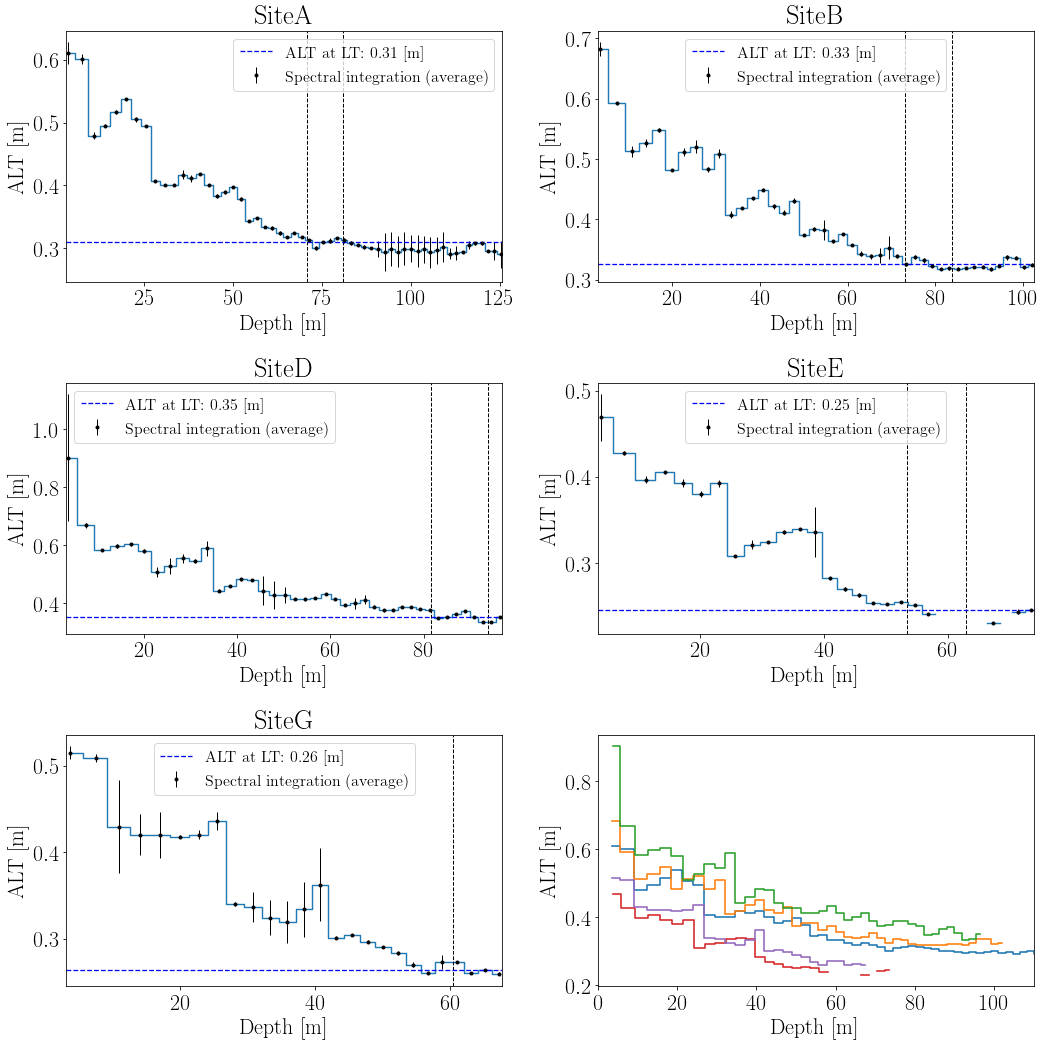

In [4]:
fig, axs = plt.subplots(int(np.ceil(len(sites)/2)),2,figsize=(15,15))
plt.close()

for i,ax in zip(range(len(sites)),axs.flatten()):
    site = sites[i]

    data = pd.read_csv(pathResults + site + '_ALT_FullCore_Pshift_50.csv')
    lMean = data['lMean']
    lStd = data['lStd']
    secs = data['depth']
    
    l_LT = np.mean(lMean[(secs >= dTambs[i]) & (secs <= dLakis[i])])
    
    ax.step(secs, lMean, where='mid', lw=1.4)
    ax.errorbar(secs, lMean, lStd, c='k', fmt='.', lw=1, label='Spectral integration (average)')
    ax.set(xlim=(min(secs)-0.5, max(secs)+0.5), xlabel='Depth [m]', ylabel='ALT [m]', title=site)
    ax.axvline(dLakis[i], lw=1, ls='--', c='k')
    ax.axvline(dTambs[i], lw=1, ls='--', c='k')
    ax.axhline(l_LT, lw=1.3, ls='--', c='b', label = f'ALT at LT: {l_LT:.2f} [m]')
    ax.legend(fontsize=16)
    
    
    
    axs.flatten()[-1].step(secs, lMean, where='mid', lw=1.6)
    #axs.flatten()[-1].errorbar(secs, lMean, lStd, c='k', fmt='.', lw=1, label='Spectral integration (average)', alpha=0.6)
    axs.flatten()[-1].set(xlim=(0,110), xlabel='Depth [m]', ylabel='ALT [m]')
fig.tight_layout()

fig

In [5]:

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/' + 'AllCores_ALTs.jpg')

### P shift vs. ALT at LT

In [6]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG']
colors = ['indigo','steelblue','darkslategrey','royalblue','midnightblue']

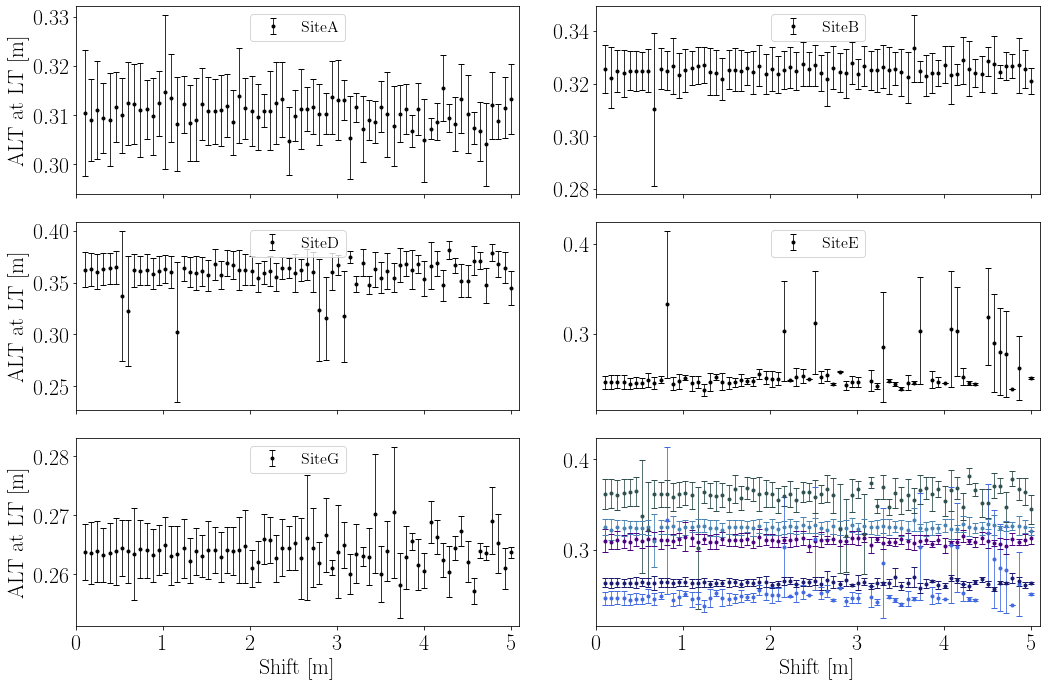

In [7]:
fig, axs = plt.subplots(int(np.ceil(len(sites)/2)),2,figsize=(15,10), sharex=True)
plt.close()

for i,ax in zip(range(len(sites)),axs.flatten()):
    site = sites[i]
    dataALTvShifts = pd.read_csv(pathResults + site+'_ALTvShifts.csv')
    ax.errorbar(dataALTvShifts['shifts'], dataALTvShifts['lMeans'], dataALTvShifts['lStds'], color='k', lw=0.8,ls='None', marker='.', capsize=3, label=site)
    ax.legend(loc='upper center',fontsize=16)
    axs.flatten()[-1].errorbar(dataALTvShifts['shifts'], dataALTvShifts['lMeans'], dataALTvShifts['lStds'], color=colors[i], lw=0.8,ls='None', marker='.', capsize=3)
    ax.set(xlim=(min(dataALTvShifts['shifts'])-0.1,max(dataALTvShifts['shifts'])+0.1))
    if i in [0,2,4]:
        ax.set(ylabel='ALT at LT [m]')
    if i in [4,5]:
        ax.set(xlabel='Shift [m]')
axs.flatten()[-1].set(xlabel='Shift [m]')
fig.tight_layout()
fig

    

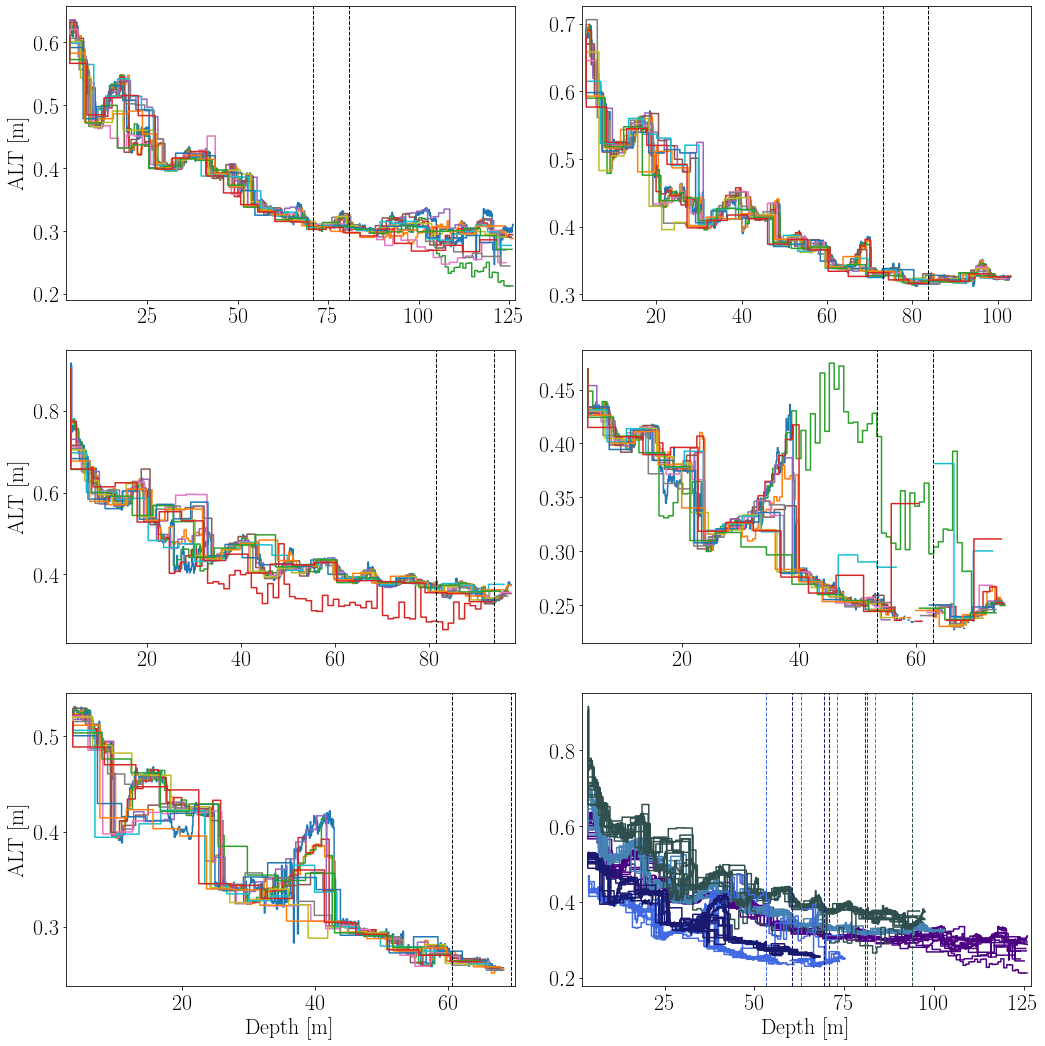

In [8]:
fig, axs = plt.subplots(int(np.ceil(len(sites)/2)),2,figsize=(15,15))
plt.close()

for i, ax in zip(range(len(sites)),axs.flatten()):
    site = sites[i]
    dataAllShifts = pd.read_csv(pathResults+site+'_ALTvDepth_AllShifts.csv')
    for j in range(len(dataALTvShifts)):
        if j%5 == 0:
            secs = dataAllShifts['secs'+str(j)]
            lMean = dataAllShifts['lMean'+str(j)]
            lStd = dataAllShifts['lStd'+str(j)]
            ax.step(secs,lMean)
            
            axs.flatten()[-1].step(secs, lMean, c=colors[i])
    ax.set(xlim=(min(secs)-1,max(secs)+5))
    ax.axvline(dLakis[i], lw=1, ls='--', c='k')
    ax.axvline(dTambs[i], lw=1, ls='--', c='k')
    
    axs.flatten()[-1].axvline(dLakis[i], lw=1, ls='--', c=colors[i])
    axs.flatten()[-1].axvline(dTambs[i], lw=1, ls='--', c=colors[i])
    if i in [0,2,4]:
        ax.set(ylabel='ALT [m]')
    if i in [4,5]:
        ax.set(xlabel='Depth [m]')

axs.flatten()[-1].set(xlabel='Depth [m]', xlim=(2,127))
fig.tight_layout()
fig

In [9]:
dataALTvLens = pd.read_csv(pathResults+site+'_ALTvLens.csv')
dataAllLens = pd.read_csv(pathResults+site+'_ALTvDepth_AllLens.csv')

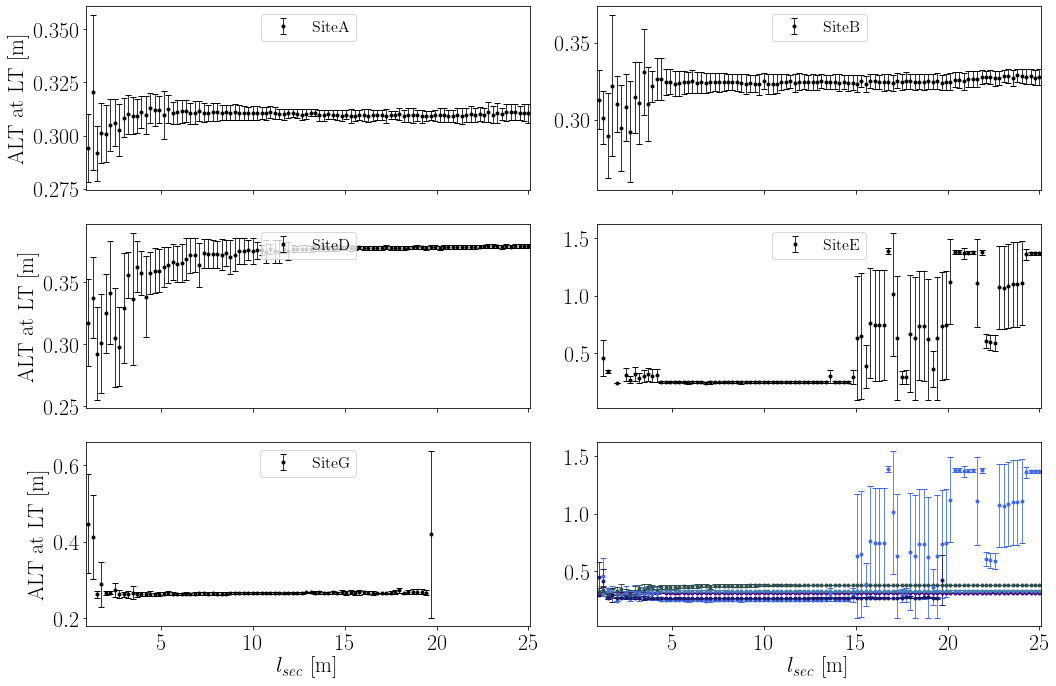

In [10]:
fig, axs = plt.subplots(int(np.ceil(len(sites)/2)),2,figsize=(15,10), sharex=True)
plt.close()

for i,ax in zip(range(len(sites)),axs.flatten()):
    site = sites[i]
    dataALTvLens = pd.read_csv(pathResults+site+'_ALTvLens.csv')
    ax.errorbar(dataALTvLens['lens'], dataALTvLens['lMeans'], dataALTvLens['lStds'], color='k', lw=0.8,ls='None', marker='.', capsize=3, label=site)
    ax.legend(loc='upper center',fontsize=16)
    axs.flatten()[-1].errorbar(dataALTvLens['lens'], dataALTvLens['lMeans'], dataALTvLens['lStds'], color=colors[i], lw=0.8,ls='None', marker='.', capsize=3)
    ax.set(xlim=(min(dataALTvLens['lens'])-0.1,max(dataALTvLens['lens'])+0.1))
    if i in [0,2,4]:
        ax.set(ylabel='ALT at LT [m]')
    if i in [4,5]:
        ax.set(xlabel='$l_{sec}$ [m]')
axs.flatten()[-1].set(xlabel='$l_{sec}$ [m]')
fig.tight_layout()
fig

    

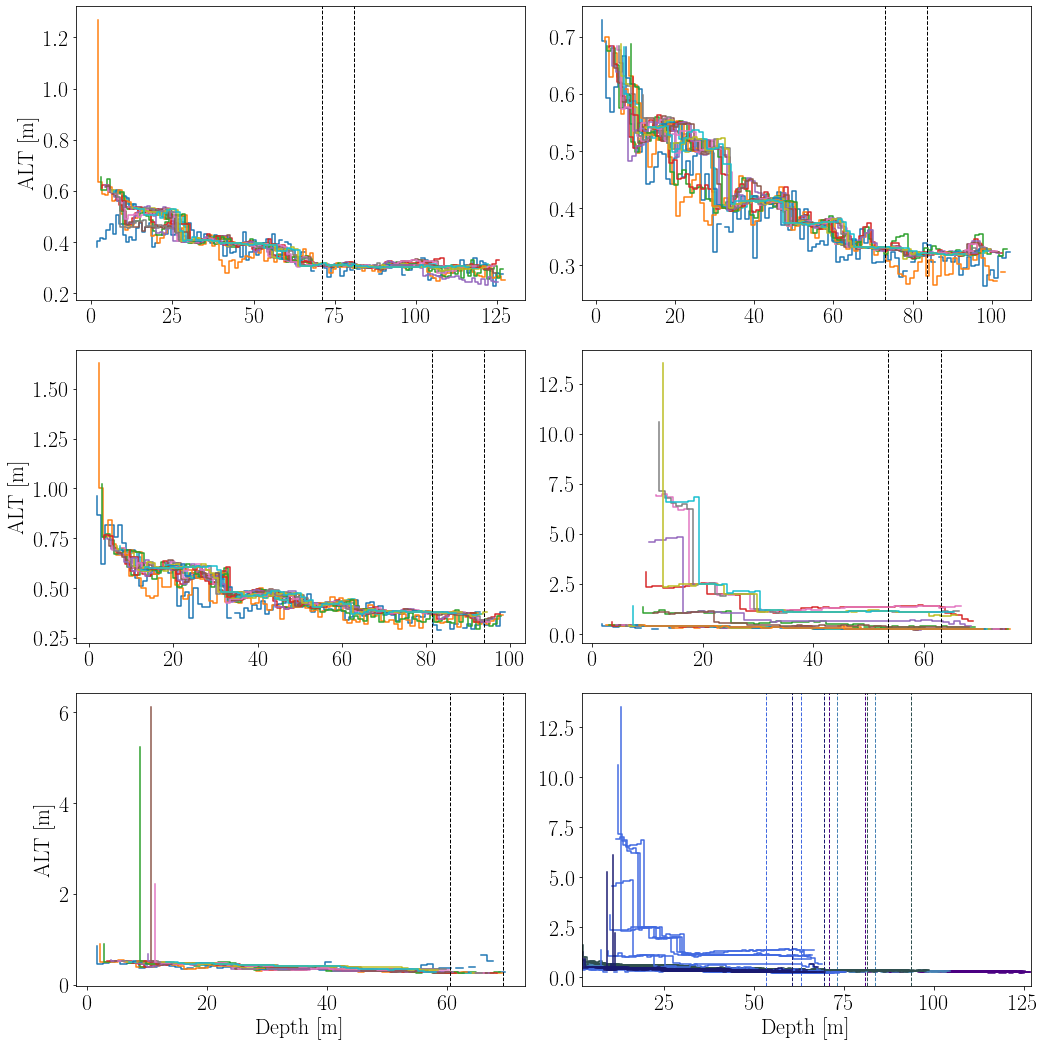

In [11]:
fig, axs = plt.subplots(int(np.ceil(len(sites)/2)),2,figsize=(15,15))
plt.close()

for i, ax in zip(range(len(sites)),axs.flatten()):
    site = sites[i]
    dataAllLens = pd.read_csv(pathResults+site+'_ALTvDepth_AllLens.csv')
    for j in range(len(dataALTvLens)):
        if j%5 == 0:
            secs = dataAllLens['secs'+str(j)]
            lMean = dataAllLens['lMean'+str(j)]
            lStd = dataAllLens['lStd'+str(j)]
            ax.step(secs,lMean)
            
            axs.flatten()[-1].step(secs, lMean, c=colors[i])
    #ax.set(xlim=(min(secs)-1,max(secs)+5))
    ax.axvline(dLakis[i], lw=1, ls='--', c='k')
    ax.axvline(dTambs[i], lw=1, ls='--', c='k')
    
    axs.flatten()[-1].axvline(dLakis[i], lw=1, ls='--', c=colors[i])
    axs.flatten()[-1].axvline(dTambs[i], lw=1, ls='--', c=colors[i])
    if i in [0,2,4]:
        ax.set(ylabel='ALT [m]')
    if i in [4,5]:
        ax.set(xlabel='Depth [m]')

axs.flatten()[-1].set(xlabel='Depth [m]', xlim=(2,127))
fig.tight_layout()
fig

# ALT effect on sigma

### Acceptance Percentage 

In [2]:
site = 'SiteB'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


In [3]:
acceptPct_dist_ins = np.linspace(0.2,1,2)
acceptPct_dist_ins

array([0.2, 1. ])

SyntaxError: unexpected EOF while parsing (<ipython-input-4-305a9fba17f3>, line 8)

In [5]:
dataAll = pd.DataFrame({'depth':depth,'d18O':d18O}, index=None)
Trans = ['DCT', 'NDCT', 'FFT']

instDCT = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30, transType = Trans[0])

for i in range(len(acceptPct_dist_ins)):
    print(f'{i+1}/{len(acceptPct_dist_ins)}')
    depDCT, datDCT, diffDCT, PsDCT, TsDCT, patsDCT = instDCT.BackDiffused_constraints(shift_in=2,acceptPct_dist_in=acceptPct_dist_ins[i])

1/2
ALT file does NOT exist. Computing ALT for core.
Entire core: 1.16-105.605 [m]

Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 7.42 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019
2/2
ALT file does NOT exist. Computing ALT for core.
Entire core: 1.16-105.605 [m]

Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 7.42 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019


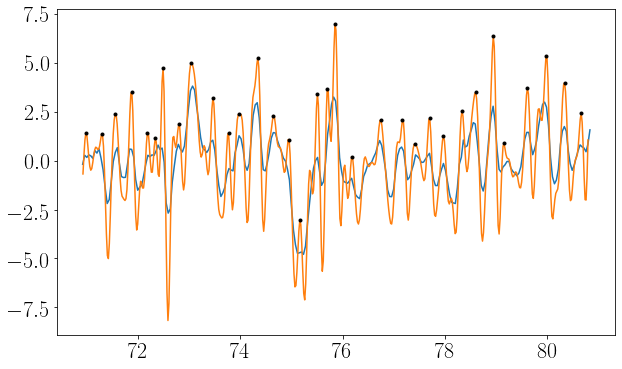

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(depth_LT, d18O_LT-np.mean(d18O_LT))
plt.plot(depDCT, datDCT)
plt.plot(depDCT[PsDCT], datDCT[PsDCT],'.', c='k')

###  Variation of mean (mean +/- std)

In [6]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG']

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

dTambs = np.zeros(len(sites))
dLakis = np.zeros(len(sites))

for i in range(len(sites)):
    coreNames = CoresSpecs['CoreName']

    core_idx = coreNames[CoresSpecs['CoreName'] == sites[i]].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTambs[i] = CoreSpecs['dTamb']
    dLakis[i] = CoreSpecs['dLaki']

In [7]:
i = 0

site = sites[i]
dLaki = dLakis[i]
dTamb = dTambs[i]
shift_in=1
lSecs_in=7
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

In [9]:

data = pd.read_csv(pathResults + site + '_ALT_FullCore_Pshift_'+str(int(shift_in))+'_lSecs_'+str(lSecs_in)+'.csv')

lDCT = np.asarray(data['lDCT']);lNDCT = np.asarray(data['lNDCT']);lFFT = np.asarray(data['lFFT']);
vals_use = data['depth']

lks = np.c_[lDCT,lNDCT,lFFT]
lks_LT = lks[(vals_use>dTamb)&(vals_use<dLaki)]
l_LT = np.mean(lks_LT)
lStd_LT = np.std(lks_LT)
print(f'ALT at LT estimate:{l_LT:.3f} +/- {lStd_LT:.3f}')

ALT at LT estimate:0.311 +/- 0.004


# No Constraints vs. Constraints

### First, a qualitative visual analysis of all cores, constrained and unconstrained

In [85]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG']

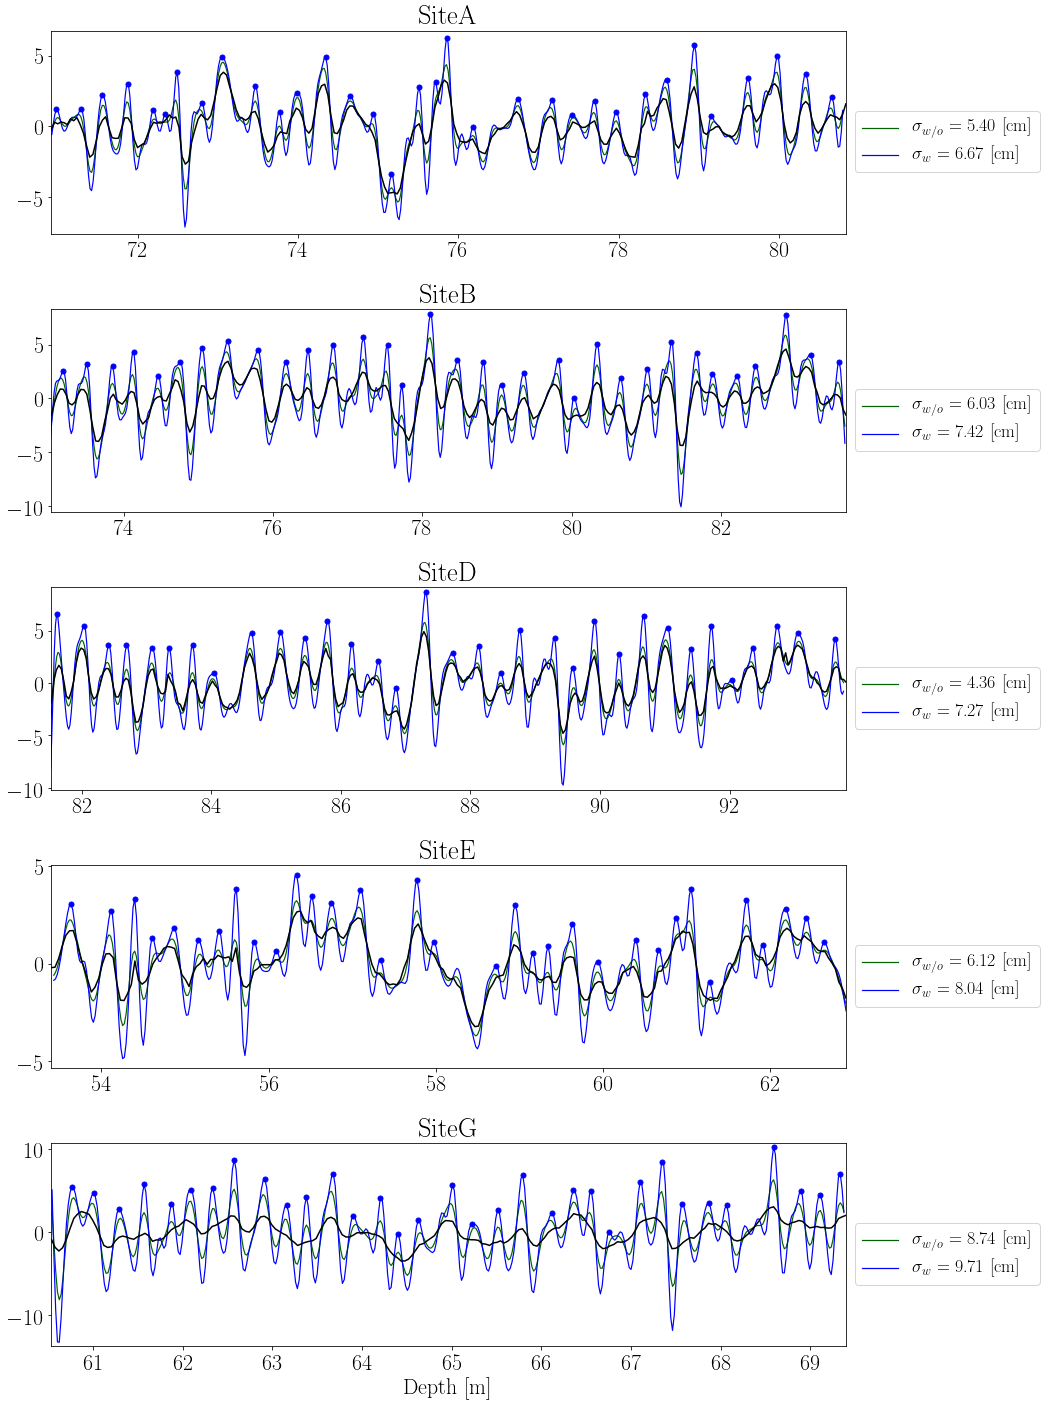

In [158]:
fig, axs = plt.subplots(len(sites),1,figsize = (15,20))

for site, i in zip(sites,range(len(sites))):

    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
    coreNames = CoresSpecs['CoreName']


    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]

    DataAll = GetCoreData(site, 'Alphabet')

    data_d18O_LT = DataAll[1]

    depth_LT = data_d18O_LT['depth']
    d18O_LT = data_d18O_LT['d18O']
    
    
    dataBD_NoConst = pd.read_csv(pathResults+site+'_EffectsSigma_NoConstraints.csv')
    depth_NoC = dataBD_NoConst['depth']; data_NoC = dataBD_NoConst['data']
    idxPeaks_NoC = dataBD_NoConst['idxPeaks'][dataBD_NoConst['idxPeaks'].notna()]
    diffLen_NoC = float(dataBD_NoConst['sigma'][dataBD_NoConst['sigma'].notna()])
    
    dataBD_Const = pd.read_csv(pathResults+site+'_EffectsSigma_Constraints.csv')    
    depth_C = dataBD_Const['depth']; data_C = dataBD_Const['data']
    idxPeaks_C = dataBD_Const['idxPeaks'][dataBD_Const['idxPeaks'].notna()]
    diffLen_C = float(dataBD_Const['sigma'][dataBD_Const['sigma'].notna()])

    axs[i].plot(depth_NoC, data_NoC, c='darkgreen', lw=1.2, label='$\sigma_{w/o}$ = '+f'{diffLen_NoC*100:.2f} [cm]')
    #axs[1].plot(depthEst[idxPeak], dataEst[idxPeak], '.', c='darkgreen', ms=10)
    axs[i].plot(depth_C, data_C, c='b', lw=1.2, label='$\sigma_w$ = '+f'{diffLen_C*100:.2f} [cm]')
    axs[i].plot(depth_C[idxPeaks_C],data_C[idxPeaks_C], '.', c='b', ms=10)
    axs[i].plot(depth_LT, d18O_LT-np.mean(d18O_LT), c='k', lw=1.5)

    axs[i].set(xlim=(min(depth_LT), max(depth_LT)), ylim=(min(data_C)-0.5, max(data_C)+0.5), title=site)
    axs[i].legend(fontsize=18,bbox_to_anchor=(1, 0.65));

axs[-1].set(xlabel='Depth [m]')    
fig.tight_layout()


In [160]:
if saveFigs:
    fig.savefig('../../WrittenWork/Figures/' + 'AllCores_ConstVNoConst.jpg')    

### Quantitative examination of diff Lens based on ALT

In [ ]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG']

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

dTambs = np.zeros(len(sites))
dLakis = np.zeros(len(sites))

for i in range(len(sites)):
    coreNames = CoresSpecs['CoreName']

    core_idx = coreNames[CoresSpecs['CoreName'] == sites[i]].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTambs[i] = CoreSpecs['dTamb']
    dLakis[i] = CoreSpecs['dLaki']

In [210]:
for i in range(len(sites)):
    site = sites[i]

    data = pd.read_csv(pathResults + site + '_ALT_FullCore_Pshift_50.csv')
    lDCT = data['lDCT']
    lNDCT = data['lNDCT']
    lFFT = data['lFFT']
    secs = data['depth']
    
    lDCT_LT = lDCT[(secs >= dTambs[i]) & (secs <= dLakis[i])]
    lNDCT_LT = lNDCT[(secs >= dTambs[i]) & (secs <= dLakis[i])]
    lFFT_LT = lFFT[(secs >= dTambs[i]) & (secs <= dLakis[i])]
    lsToMean = np.asarray(pd.concat([lDCT_LT,lNDCT_LT,lFFT_LT]))[np.where(pd.concat([lDCT_LT,lNDCT_LT,lFFT_LT])>0)[0]]
    lMean = np.mean(lsToMean)
    lStd = np.std(lsToMean)
    print('\t####'+site+'####')
    print(f'ALT estimate: {lMean:.3f} +/- {lStd:.3f}\n')

	####SiteA####
ALT estimate: 0.311 +/- 0.006

	####SiteB####
ALT estimate: 0.326 +/- 0.008

	####SiteD####
ALT estimate: 0.354 +/- 0.012

	####SiteE####
ALT estimate: 0.246 +/- 0.005

	####SiteG####
ALT estimate: 0.264 +/- 0.006



# LT location distributions

### Variation over entire deposition sections (gauss distribution)

In [2]:
site = 'SiteA'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb_in = CoreSpecs['dTambCor']
dLaki_in = CoreSpecs['dLakiCor']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


#### Vary both L and T

In [343]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

diffLens, dTambs, dLakis = np.array(pd.read_csv(pathResults + site+'diffLens_GaussDistwDepths.csv', ' ', header=None))


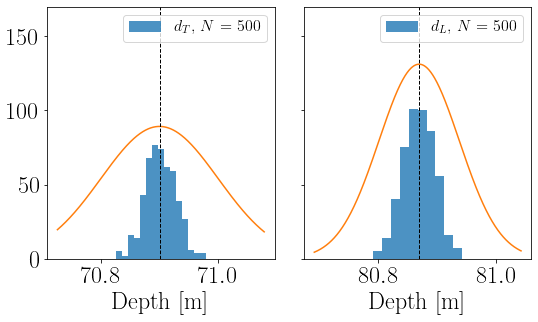

In [12]:

mu1 = dTamb_in
mu2 = dLaki_in

sig1 = CoreSpecs['lenTambCor']/400
sig2 = CoreSpecs['lenLakiCor']/500

xs1 = np.linspace(min(dTambs)-0.1, max(dTambs)+0.1, 1000)
xs2 = np.linspace(min(dLakis)-0.1, max(dLakis)+0.1, 1000)
gauss1 = func_gaussian(xs1, np.sqrt(500), mu1, sig1, 0)
gauss2 = func_gaussian(xs2, np.sqrt(500), mu2, sig2, 0)



fig, ax = plt.subplots(1,2,figsize=(8,5), sharey=True)

ax[0].hist(dTambs, alpha=0.8, bins=15, label='$d_{T}$, $N$ = '+f'{len(dTambs)}')
ax[0].plot(xs1, gauss1)
ax[0].axvline(np.mean(dTambs), c='k', lw=1,ls='--')
ax[0].legend(fontsize=16)
ax[0].set(xlabel = 'Depth [m]', ylim=(0,170))

ax[1].hist(dLakis, alpha=0.8, bins=10, label='$d_{L}$, $N$ = '+f'{len(dTambs)}')
ax[1].plot(xs2, gauss2)
ax[1].axvline(np.mean(dLakis), c='k', lw=1,ls='--')
ax[1].legend(fontsize=16)
ax[1].set(xlabel = 'Depth [m]')
fig.tight_layout()

In [345]:
sigMin = 0.0
sigMax = 0.15

diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
dTambsUse = dTambs[(diffLens>sigMin) & (diffLens < sigMax)]
dLakisUse = dLakis[(diffLens>sigMin) & (diffLens < sigMax)]
#diffLensUse[diffLensUse<0.04] = 0.047


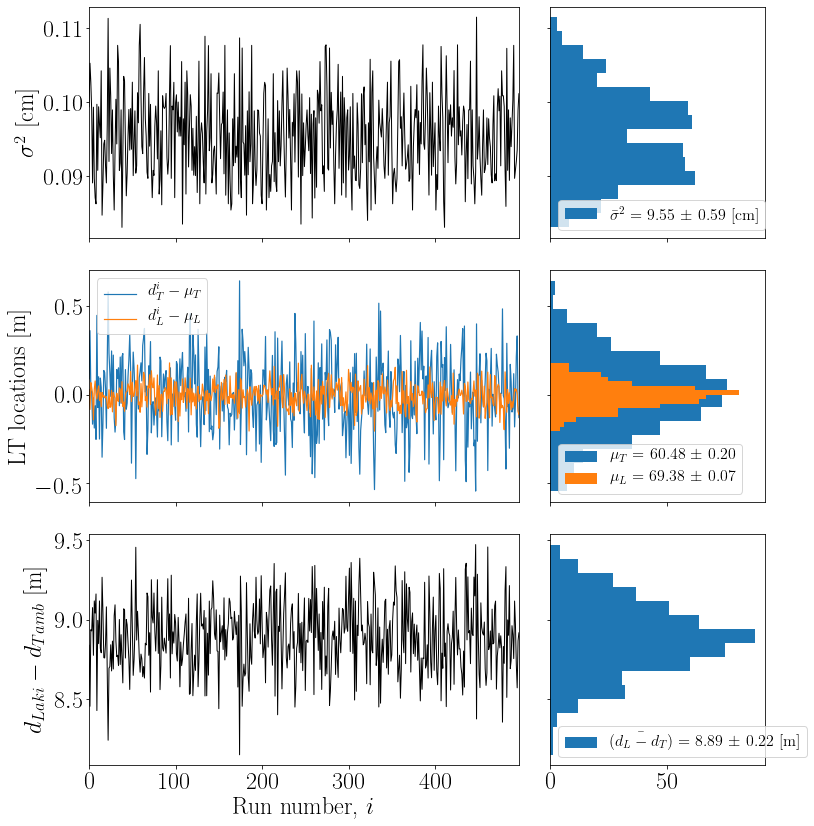

In [346]:
x = np.arange(0,len(diffLensUse))

sigmaMean = np.mean(diffLensUse)*100
sigmaSTD = np.std(diffLensUse)*100
sigmaMean_LT = np.mean(dLakis-dTambs)
sigmaSTD_LT = np.std(dLakis-dTambs)

fig, ax = plt.subplots(3,2,gridspec_kw={'width_ratios':[2,1]},figsize=(12,12), sharex='col', sharey='row')

mpl.rcParams['font.size'] = 24

ax[0,0].plot(x,diffLensUse,c='k',lw=1)
ax[0,0].set(xlim=(min(x),max(x)), ylabel='$\sigma^2$ [cm]')
ax[0,1].hist(diffLensUse, bins=15, orientation="horizontal", label=r'$\bar\sigma^2 =$ ' + f'{sigmaMean:.2f} $\pm$ {sigmaSTD:.2f} [cm]');
#ax[0,1].set(xlabel='Counts')
ax[0,1].legend(fontsize=16, loc='lower left')

ax[1,0].plot(x,dTambsUse-mu1,lw=1.2, label='$d_{T}^i-\mu_{T}$')
ax[1,0].plot(x,dLakisUse-mu2,lw=1.2,  label='$d_{L}^i-\mu_{L}$')
ax[1,0].set(xlim=(min(x),max(x)), ylabel='LT locations [m]')
ax[1,0].legend(fontsize=16)
ax[1,1].hist(dTambsUse-mu1, bins=15, orientation="horizontal", label=f'$\mu_T = $ {mu1:.2f} $\pm$ {sig1:.2f}');
ax[1,1].hist(dLakisUse-mu2, bins=15, orientation="horizontal", label=f'$\mu_L = $ {mu2:.2f} $\pm$ {sig2:.2f}');
ax[1,1].legend(fontsize=16, loc='lower left')

ax[2,0].plot(x,dLakisUse-dTambsUse,c='k',lw=1)
ax[2,0].set(xlim=(min(x),max(x)), xlabel='Run number, $i$', ylabel='$d_{Laki}-d_{Tamb}$ [m]')
ax[2,1].hist(dLakisUse-dTambsUse, bins=15, orientation="horizontal", label=r'$\bar{(d_{L}-d_{T})} =$ ' + f'{sigmaMean_LT:.2f} $\pm$ {sigmaSTD_LT:.2f} [m]')
ax[2,1].legend(fontsize=16, loc='lower left')

fig.tight_layout()

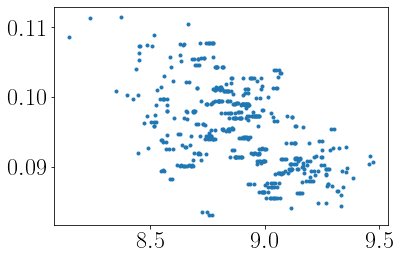

In [347]:
plt.plot(dLakisUse-dTambsUse, diffLensUse,'.')

#### Vary only L

In [348]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

diffLens, dTambs, dLakis = np.array(pd.read_csv(pathResults + site+'_diffLens_GaussDistwDepths_Laki.csv', ' ', header=None))

from scipy import stats
from scipy.stats import binom, poisson, norm

In [349]:
sigMin = 0.0
sigMax = 0.15

diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
dTambsUse = dTambs[(diffLens>sigMin) & (diffLens < sigMax)]
dLakisUse = dLakis[(diffLens>sigMin) & (diffLens < sigMax)]
#diffLensUse[diffLensUse<0.04] = 0.047


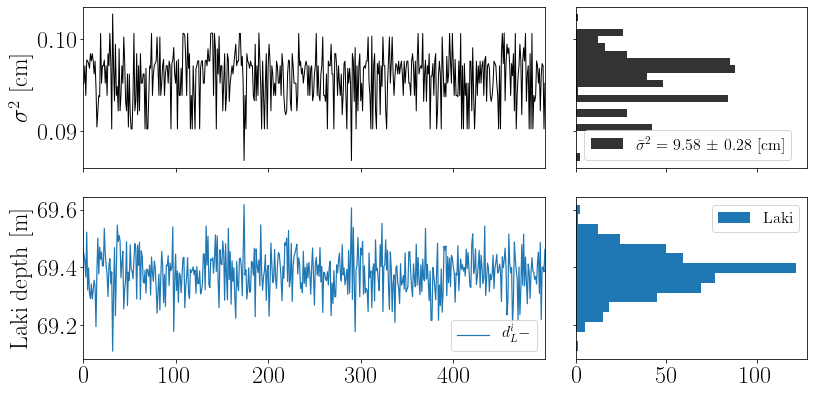

In [350]:
x = np.arange(0,len(diffLensUse))

sigmaMean = np.mean(diffLensUse)*100
sigmaSTD = np.std(diffLensUse)*100
sigmaMean_LT = np.mean(dLakis-dTambs)
sigmaSTD_LT = np.std(dLakis-dTambs)

fig, ax = plt.subplots(2,2,gridspec_kw={'width_ratios':[2,1]},figsize=(12,6), sharex='col', sharey='row')

mpl.rcParams['font.size'] = 24

ax[0,0].plot(x,diffLensUse,c='k',lw=1)
ax[0,0].set(xlim=(min(x),max(x)), ylabel='$\sigma^2$ [cm]')
ax[0,1].hist(diffLensUse, bins=20, orientation="horizontal", color='k',alpha=0.8,label=r'$\bar\sigma^2 =$ ' + f'{sigmaMean:.2f} $\pm$ {sigmaSTD:.2f} [cm]');
#ax[0,1].set(xlabel='Counts')
ax[0,1].legend(fontsize=16, loc='lower left')

#ax[1,0].plot(x,dTambsUse,lw=1.2, label='$d_{T}^i$')
ax[1,0].plot(x,dLakisUse,lw=1.2,  label='$d_{L}^i-$')
ax[1,0].set(xlim=(min(x),max(x)), ylabel='Laki depth [m]')
ax[1,0].legend(fontsize=16)
#ax[1,1].hist(dTambsUse, bins=15, orientation="horizontal");
ax[1,1].hist(dLakisUse, bins=15, orientation="horizontal", label='Laki');
ax[1,1].legend(fontsize=16)

fig.tight_layout()

#### Vary only T

In [351]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

diffLens, dTambs, dLakis = np.array(pd.read_csv(pathResults + site+'_diffLens_GaussDistwDepths_Tamb.csv', ' ', header=None))


In [352]:
sigMin = 0.0
sigMax = 0.15

diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
dTambsUse = dTambs[(diffLens>sigMin) & (diffLens < sigMax)]
dLakisUse = dLakis[(diffLens>sigMin) & (diffLens < sigMax)]
#diffLensUse[diffLensUse<0.04] = 0.047


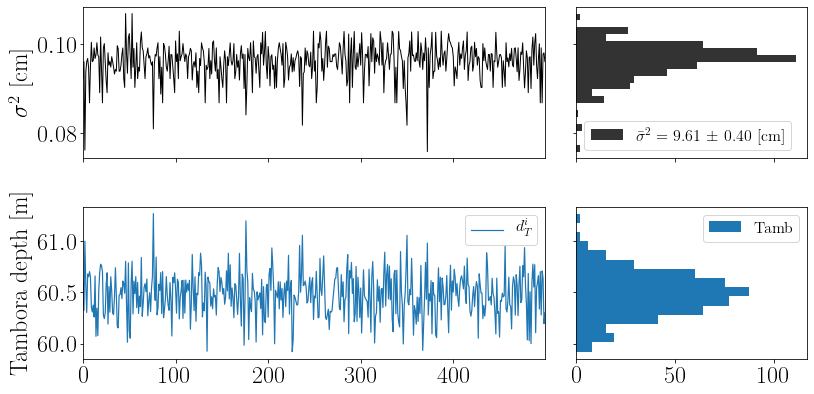

In [353]:
x = np.arange(0,len(diffLensUse))

sigmaMean = np.mean(diffLensUse)*100
sigmaSTD = np.std(diffLensUse)*100
sigmaMean_LT = np.mean(dLakis-dTambs)
sigmaSTD_LT = np.std(dLakis-dTambs)

fig, ax = plt.subplots(2,2,gridspec_kw={'width_ratios':[2,1]},figsize=(12,6), sharex='col', sharey='row')

mpl.rcParams['font.size'] = 24

ax[0,0].plot(x,diffLensUse,c='k',lw=1)
ax[0,0].set(xlim=(min(x),max(x)), ylabel='$\sigma^2$ [cm]')
ax[0,1].hist(diffLensUse, bins=20, orientation="horizontal", color='k',alpha=0.8, label=r'$\bar\sigma^2 =$ ' + f'{sigmaMean:.2f} $\pm$ {sigmaSTD:.2f} [cm]');
#ax[0,1].set(xlabel='Counts')
ax[0,1].legend(fontsize=16, loc='lower left')

ax[1,0].plot(x,dTambsUse,lw=1.2, label='$d_{T}^i$')
#ax[1,0].plot(x,dLakisUse,lw=1.2,  label='$d_{L}^i-$')
ax[1,0].set(xlim=(min(x),max(x)), ylabel='Tambora depth [m]')
ax[1,0].legend(fontsize=16)
ax[1,1].hist(dTambsUse, bins=15, orientation="horizontal", label='Tamb');
#ax[1,1].hist(dLakisUse, bins=15, orientation="horizontal", label='Laki');
ax[1,1].legend(fontsize=16)

fig.tight_layout()

### Variation corresponding to ~2 months

In [3]:
#site = 'SiteG'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb_in = CoreSpecs['dTambCor']
dLaki_in = CoreSpecs['dLakiCor']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


In [4]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

data = pd.read_csv(pathResults + site + '_ALT_FullCore_Pshift_'+str(int(1.5))+'_lSecs_'+str(7)+'.csv')

lDCT = np.asarray(data['lDCT']);lNDCT = np.asarray(data['lNDCT']);lFFT = np.asarray(data['lFFT']);
vals_use = data['depth']

lks = np.c_[lDCT,lNDCT,lFFT]
lks_LT = lks[(vals_use>=dTamb_in)&(vals_use<=dLaki_in)]


def avg(a):
    return a[a > 0].mean()
def std(a):
    return a[a>0].std()

l_LT = avg(lks_LT)
lStd_LT = std(lks_LT)

In [5]:
MLT = l_LT/6

mu = dTamb_in
mu2 = dLaki_in
sig = MLT

ds = np.linspace(dTamb_in-2,dLaki_in+2, 1000)
fs = func_gaussian(ds, 1, mu, sig, 0)
fs2 = func_gaussian(ds, 1, mu2, sig, 0)


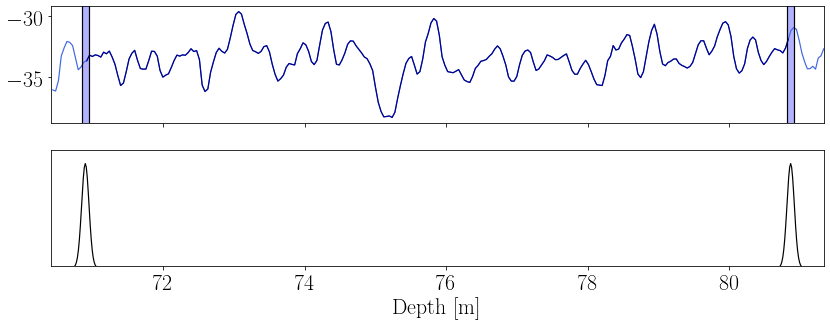

In [6]:
fig, ax = plt.subplots(2,1,figsize=(12,5), sharex=True)
delt = .5
ax[0].plot(depth[(depth > dTamb_in - delt) & (depth < dLaki_in + delt)],d18O[(depth > dTamb_in - delt) & (depth < dLaki_in + delt)], c='royalblue', lw=1.2)
ax[0].plot(depth_LT, d18O_LT, c='darkblue', lw=1.2)
ax[0].set(xlim=(min(depth_LT)-delt,max(depth_LT)+delt))
ax[0].axvline(mu-sig, lw=1.2, c='k')
ax[0].axvline(mu+sig,lw=1.2, c='k')

ax[0].axvline(dLaki_in-sig, lw=1.2, c='k')
ax[0].axvline(dLaki_in+sig,lw=1.2, c='k')
ax[0].axvspan(dLaki_in-sig, dLaki_in+sig, alpha=0.3, color='b')
ax[0].axvspan(dTamb_in-sig, dTamb_in+sig, alpha=0.3, color='b')

ax[1].plot(ds,fs, c='k', lw=1.2)
ax[1].plot(ds,fs2, c='k', lw=1.2)
ax[1].set(ylim=(0.1,max(fs)+1), xlabel='Depth [m]')
ax[1].axes.yaxis.set_visible(False)

fig.tight_layout()

#### Spectral transform: DCT

In [23]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

diffLens, dTambs, dLakis = np.array(pd.read_csv(pathResults + site+'_diffLens_GaussDistwDepths_sigNmonths2.csv', ' ', header=None))

from scipy import stats
from scipy.stats import binom, poisson, norm

In [24]:
sigMin = 0.0
sigMax = 0.15

diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
dTambsUse = dTambs[(diffLens>sigMin) & (diffLens < sigMax)]
dLakisUse = dLakis[(diffLens>sigMin) & (diffLens < sigMax)]
#diffLensUse[diffLensUse<0.04] = 0.047


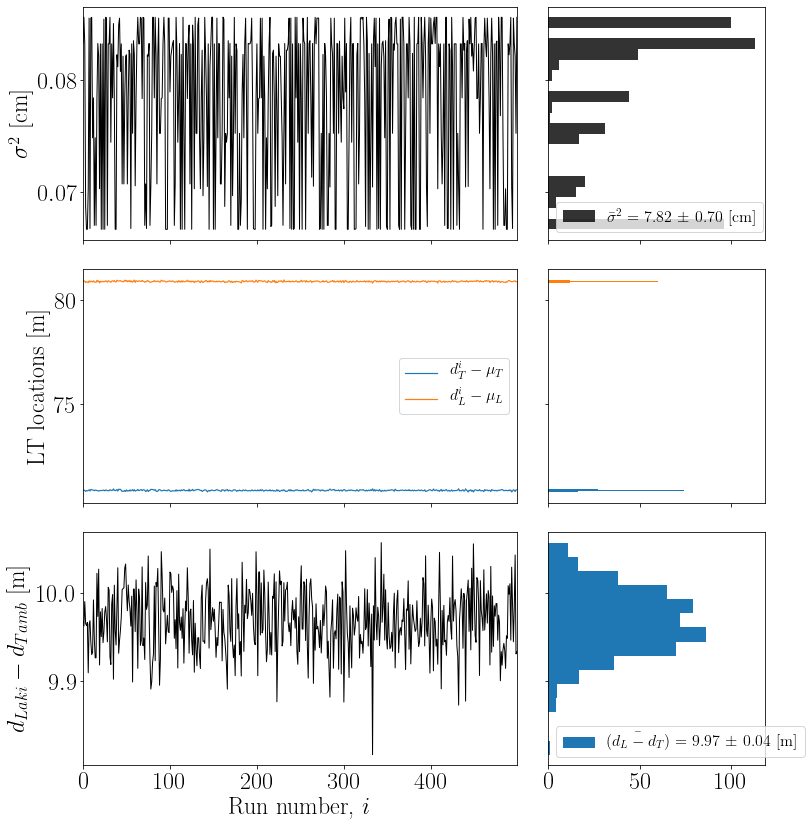

In [25]:
x = np.arange(0,len(diffLensUse))

sigmaMean = np.mean(diffLensUse)*100
sigmaSTD = np.std(diffLensUse)*100
sigmaMean_LT = np.mean(dLakis-dTambs)
sigmaSTD_LT = np.std(dLakis-dTambs)

fig, ax = plt.subplots(3,2,gridspec_kw={'width_ratios':[2,1]},figsize=(12,12), sharex='col', sharey='row')

mpl.rcParams['font.size'] = 24

ax[0,0].plot(x,diffLensUse,c='k',lw=1)#,marker='.',ls='None')
ax[0,0].set(xlim=(min(x),max(x)), ylabel='$\sigma^2$ [cm]')
ax[0,1].hist(diffLensUse, bins=20, orientation="horizontal", color='k',alpha=0.8, label=r'$\bar\sigma^2 =$ ' + f'{sigmaMean:.2f} $\pm$ {sigmaSTD:.2f} [cm]');
#ax[0,1].set(xlabel='Counts')
ax[0,1].legend(fontsize=16, loc='lower left')

ax[1,0].plot(x,dTambsUse,lw=1.2, label='$d_{T}^i-\mu_{T}$')
ax[1,0].plot(x,dLakisUse,lw=1.2,  label='$d_{L}^i-\mu_{L}$')
ax[1,0].set(xlim=(min(x),max(x)), ylabel='LT locations [m]')
ax[1,0].legend(fontsize=16)
ax[1,1].hist(dTambsUse, bins=15, orientation="horizontal")#, label=f'$\mu_T = $ {mu1:.2f} $\pm$ {sig1:.2f}');
ax[1,1].hist(dLakisUse, bins=15, orientation="horizontal")#, label=f'$\mu_L = $ {mu2:.2f} $\pm$ {sig2:.2f}');
#ax[1,1].legend(fontsize=16, loc='center left')

ax[2,0].plot(x,dLakisUse-dTambsUse,c='k',lw=1)
ax[2,0].set(xlim=(min(x),max(x)), xlabel='Run number, $i$', ylabel='$d_{Laki}-d_{Tamb}$ [m]')
ax[2,1].hist(dLakisUse-dTambsUse, bins=15, orientation="horizontal", label=r'$\bar{(d_{L}-d_{T})} =$ ' + f'{sigmaMean_LT:.2f} $\pm$ {sigmaSTD_LT:.2f} [m]')
ax[2,1].legend(fontsize=16, loc='lower left')

fig.tight_layout()

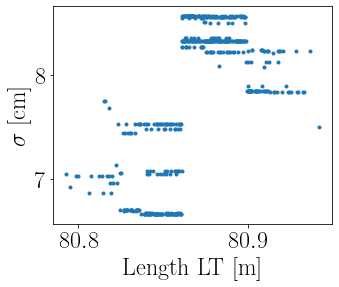

In [26]:
fig, ax = plt.subplots(figsize=(5,4))
plt.plot(dLakisUse, diffLensUse*100,'.')
ax.set(xlabel='Length LT [m]', ylabel='$\sigma$ [cm]');

#### Spectral transform: NDCT

In [38]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'
site = 'SiteE'
diffLens, dTambs, dLakis = np.array(pd.read_csv(pathResults + site+'_diffLens_GaussDistwDepths_sigNmonths2_NDCT2.csv', ' ', header=None))

from scipy import stats
from scipy.stats import binom, poisson, norm

In [44]:
sigMin = 0.0
sigMax = 0.15

diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
dTambsUse = dTambs[(diffLens>sigMin) & (diffLens < sigMax)]
dLakisUse = dLakis[(diffLens>sigMin) & (diffLens < sigMax)]
#diffLensUse[diffLensUse<0.04] = 0.047


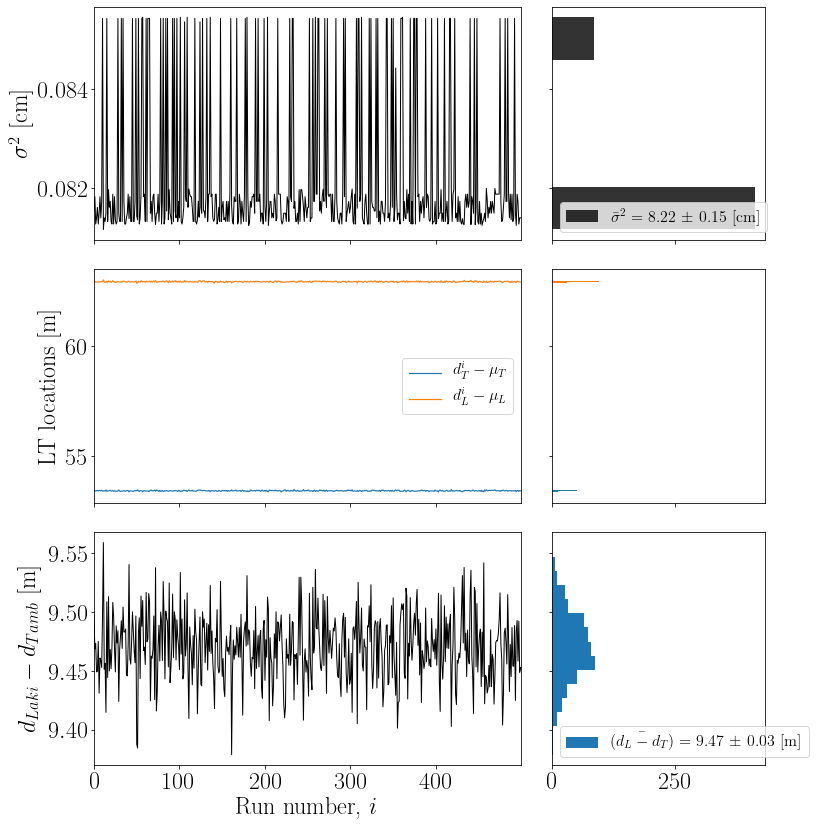

In [45]:
x = np.arange(0,len(diffLensUse))

sigmaMean = np.mean(diffLensUse)*100
sigmaSTD = np.std(diffLensUse)*100
sigmaMean_LT = np.mean(dLakis-dTambs)
sigmaSTD_LT = np.std(dLakis-dTambs)

fig, ax = plt.subplots(3,2,gridspec_kw={'width_ratios':[2,1]},figsize=(12,12), sharex='col', sharey='row')

mpl.rcParams['font.size'] = 24

ax[0,0].plot(x,diffLensUse,c='k',lw=1)#,marker='.',ls='None')
ax[0,0].set(xlim=(min(x),max(x)), ylabel='$\sigma^2$ [cm]')
ax[0,1].hist(diffLensUse, bins=5, orientation="horizontal", color='k',alpha=0.8, label=r'$\bar\sigma^2 =$ ' + f'{sigmaMean:.2f} $\pm$ {sigmaSTD:.2f} [cm]');
#ax[0,1].set(xlabel='Counts')
ax[0,1].legend(fontsize=16, loc='lower left')

ax[1,0].plot(x,dTambsUse,lw=1.2, label='$d_{T}^i-\mu_{T}$')
ax[1,0].plot(x,dLakisUse,lw=1.2,  label='$d_{L}^i-\mu_{L}$')
ax[1,0].set(xlim=(min(x),max(x)), ylabel='LT locations [m]')
ax[1,0].legend(fontsize=16)
ax[1,1].hist(dTambsUse, bins=15, orientation="horizontal")#, label=f'$\mu_T = $ {mu1:.2f} $\pm$ {sig1:.2f}');
ax[1,1].hist(dLakisUse, bins=15, orientation="horizontal")#, label=f'$\mu_L = $ {mu2:.2f} $\pm$ {sig2:.2f}');
#ax[1,1].legend(fontsize=16, loc='center left')

ax[2,0].plot(x,dLakisUse-dTambsUse,c='k',lw=1)
ax[2,0].set(xlim=(min(x),max(x)), xlabel='Run number, $i$', ylabel='$d_{Laki}-d_{Tamb}$ [m]')
ax[2,1].hist(dLakisUse-dTambsUse, bins=15, orientation="horizontal", label=r'$\bar{(d_{L}-d_{T})} =$ ' + f'{sigmaMean_LT:.2f} $\pm$ {sigmaSTD_LT:.2f} [m]')
ax[2,1].legend(fontsize=16, loc='lower left')

fig.tight_layout()

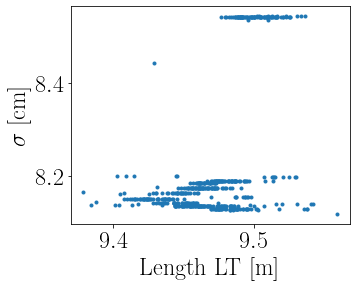

In [41]:
fig, ax = plt.subplots(figsize=(5,4))
plt.plot(dLakisUse-dTambsUse, diffLensUse*100,'.')
ax.set(xlabel='Length LT [m]', ylabel='$\sigma$ [cm]');

# Spectral Transforms Effect on Diffusion Length

In [257]:
#site = 'SiteG'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


### Sigma estimate differences

In [258]:
dataAll = pd.DataFrame({'depth':depth,'d18O':d18O}, index=None)
Trans = ['DCT', 'NDCT', 'FFT']

instDCT = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30, transType = Trans[0])

depDCT, datDCT, diffDCT, PsDCT, TsDCT, patsDCT = instDCT.BackDiffused_constraints()

ALT file exists. Loading ALT data.
Sigma fit: 7.05
Min sigma analyt: 7.69
Starting sigma: 5.05 [cm]
Final sigma: 6.67 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019


In [259]:
instNDCT = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30, transType = Trans[1])

depNDCT, datNDCT, diffNDCT, PsNDCT, TsNDCT, patsNDCT = instNDCT.BackDiffused_constraints()

ALT file exists. Loading ALT data.
Sigma fit: 7.12
Min sigma analyt: 7.69
Starting sigma: 5.12 [cm]


KeyboardInterrupt: 

In [8]:
instFFT = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30, transType = Trans[2])

depFFT, datFFT, diffFFT, PsFFT, TsFFT, patsFFT = instFFT.BackDiffused_constraints()

ALT file exists. Loading ALT data.
Hello
Sigma fit: 8.23
Min sigma analyt: 8.85
Starting sigma: 6.23 [cm]
Final sigma: 9.71 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.020


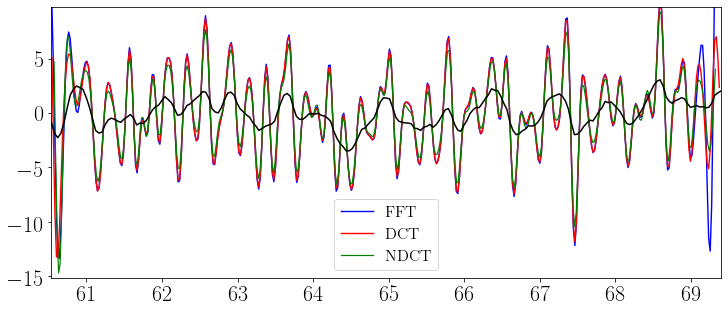

In [9]:
fig, ax = plt.subplots(figsize=(12,5))


ax.plot(depFFT,datFFT, label='FFT', c='b', lw=1.4)
ax.plot(depDCT,datDCT, label='DCT', c='r', lw=1.4)
ax.plot(depNDCT,datNDCT, label='NDCT', c='g', lw=1.2)
ax.plot(depth_LT,d18O_LT - np.mean(d18O_LT), c='k', lw=1.5)


ax.set(xlim=(min(depth_LT), max(depth_LT)), ylim=(min(datNDCT)-0.5, max(datNDCT)+0.5))
ax.legend(fontsize=16);

### Speed up/slow down

In [66]:
site = 'SiteG'
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

dTambs,dLakis, diffLenDCTs, diffLenNDCTs, diffLenFFTs, totalDCTs, totalNDCTs, totalFFTs = np.array(pd.read_csv(pathResults + site+'_diffLens_SpecTransEffect_wTiming_varyLandT.csv', ' ', header=None))

from scipy import stats
from scipy.stats import binom, poisson, norm

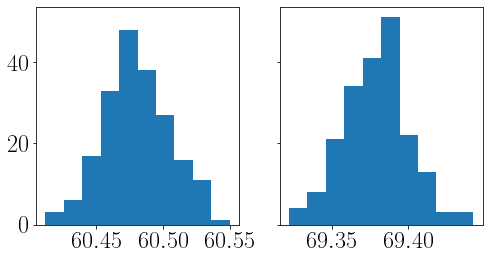

In [67]:
fig, ax = plt.subplots(1,2,figsize=(8,4), sharey=True)
ax[0].hist(dTambs, bins=10);
ax[1].hist(dLakis, bins=10);

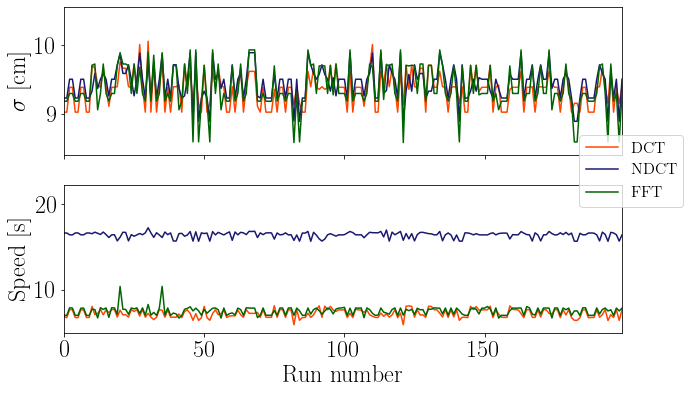

In [68]:
x = np.arange(0,len(dTambs))


fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
sigDCT = ax[0].plot(x,diffLenDCTs*100, label='DCT', c='orangered')
sigNDCT = ax[0].plot(x,diffLenNDCTs*100, label='NDCT', c='midnightblue')
sigFFT = ax[0].plot(x,diffLenFFTs*100, label='FFT', c='darkgreen')
ax[0].set(xlim=(min(x),max(x)), ylim=(min(diffLenNDCTs*100)-0.5,max(diffLenDCTs*100)+0.5), ylabel = '$\sigma$ [cm]')

tDCT = ax[1].plot(x, totalDCTs, c='orangered')
tNDCT = ax[1].plot(x, totalNDCTs, c='midnightblue')
tFFT = ax[1].plot(x, totalFFTs, c='darkgreen')
ax[1].set(xlim=(min(x),max(x)), ylim=(min(totalDCTs)-1,max(totalNDCTs)+5), xlabel='Run number', ylabel='Speed [s]')

handles, labels = ax[0].get_legend_handles_labels()
#fig.legend((sigDCT, sigNDCT, sigFFT), ('DCT', 'NDCT','FFT'))#, loc = (0.5, 0), ncol=5 )
fig.legend(handles,labels, fontsize=16, loc=(0.84,0.475))

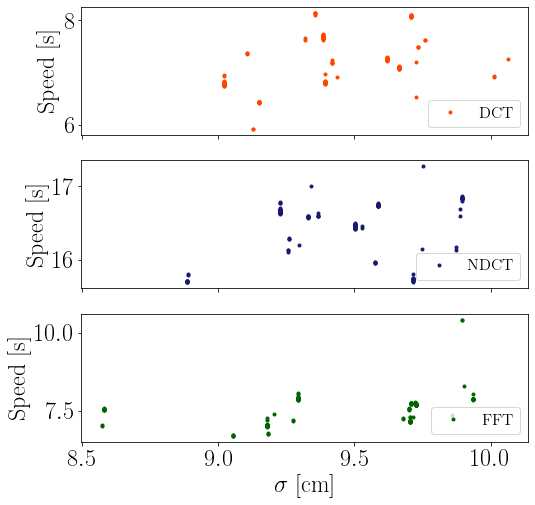

In [69]:
fig, axs = plt.subplots(3,1, figsize=(8,8), sharex=True)

axs[0].plot(diffLenDCTs*100, totalDCTs,'.', c='orangered', label='DCT')
axs[1].plot(diffLenNDCTs*100, totalNDCTs,'.', c='midnightblue', label='NDCT')
axs[2].plot(diffLenFFTs*100, totalFFTs,'.', c='darkgreen', label='FFT')
axs[2].set(xlabel='$\sigma$ [cm]', ylabel='Speed [s]')
axs[1].set(ylabel='Speed [s]')
axs[0].set(ylabel='Speed [s]')

axs[0].legend(fontsize=16, loc='lower right')
axs[1].legend(fontsize=16, loc='lower right')
axs[2].legend(fontsize=16, loc='lower right')

# Interpolation bf. vs. Diffusion Length

## Quantitatively, delta vs. diff len

## Qualitatively, focus on specific resampling

In [146]:
j = 0
interpType = 'CubicSpline'
deltaMins = [0.015,0.015,0.015,0.015,0.015]
deltaMaxs = [0.1,0.1,0.12,0.1,0.1]

    # Load data
site = sites[j]
delta_arr = np.linspace(deltaMins[j],deltaMaxs[j],5)


N_InInt = 33

print(f'\n {site}')
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']

isoData = data_d18O


interval = np.array([min(depth_LT), max(depth_LT)])
interpTypeAll = interpType

diffLens = np.zeros(len(delta_arr))
Npeaks = np.zeros(len(delta_arr))
depths_BD = []
datas_BD = []
depth_ints = []
data_ints = []
peakss = []
troughss = []
patss = []

for i in range(len(delta_arr)):
    print(f'\nRun {i}')
    print(f'Delta: {delta_arr[i]:.3f}\n')
    inst = Interpolation(depth_LT, pd.Series(d18O_LT), interval, interpTypeAll, DeltaInput=True, samplingSize=delta_arr[i])
    depth_LT_int1, d18O_LT_int1, Delta = inst()

    depth_ints.append(depth_LT_int1)
    data_ints.append(d18O_LT_int1)

    dataAll = pd.DataFrame({'depth':depth_LT_int1,'d18O':d18O_LT_int1}, index=None)

    inst = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
    depth1, data, diffLen, Peaks, Ts, pats = inst.BackDiffused_constraints(interpAfterDecon=False)
    # depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=False, newDelta=0.005)

    Npeaks[i] = len(Peaks)
    diffLens[i] = diffLen
    depths_BD.append(depth1)
    datas_BD.append(data)
    peakss.append(Peaks)
    troughss.append(Ts)
    patss.append(patss)


 SiteA

Run 0
Delta: 0.015

ALT file exists. Loading ALT data.
Sigma fit: 4.90
Min sigma analyt: 7.69
Starting sigma: 2.90 [cm]
Final sigma: 3.64 [cm]
Final # of peaks: 33
Delta: 0.015
Delta new: 0.015

Run 1
Delta: 0.036

ALT file exists. Loading ALT data.
Sigma fit: 6.55
Min sigma analyt: 7.69
Starting sigma: 4.55 [cm]
Final sigma: 6.13 [cm]
Final # of peaks: 33
Delta: 0.036
Delta new: 0.036

Run 2
Delta: 0.058

ALT file exists. Loading ALT data.
Sigma fit: 7.63
Min sigma analyt: 7.69
Starting sigma: 5.63 [cm]
Final sigma: 8.66 [cm]
Final # of peaks: 33
Delta: 0.057
Delta new: 0.057

Run 3
Delta: 0.079

ALT file exists. Loading ALT data.
Sigma fit: 7.89
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
Final sigma: 9.62 [cm]
Final # of peaks: 33
Delta: 0.080
Delta new: 0.080

Run 4
Delta: 0.100

ALT file exists. Loading ALT data.
Sigma fit: 7.63
Min sigma analyt: 7.69
Starting sigma: 5.63 [cm]
Final sigma: 9.38 [cm]
Final # of peaks: 33
Delta: 0.101
Delta new: 0.101


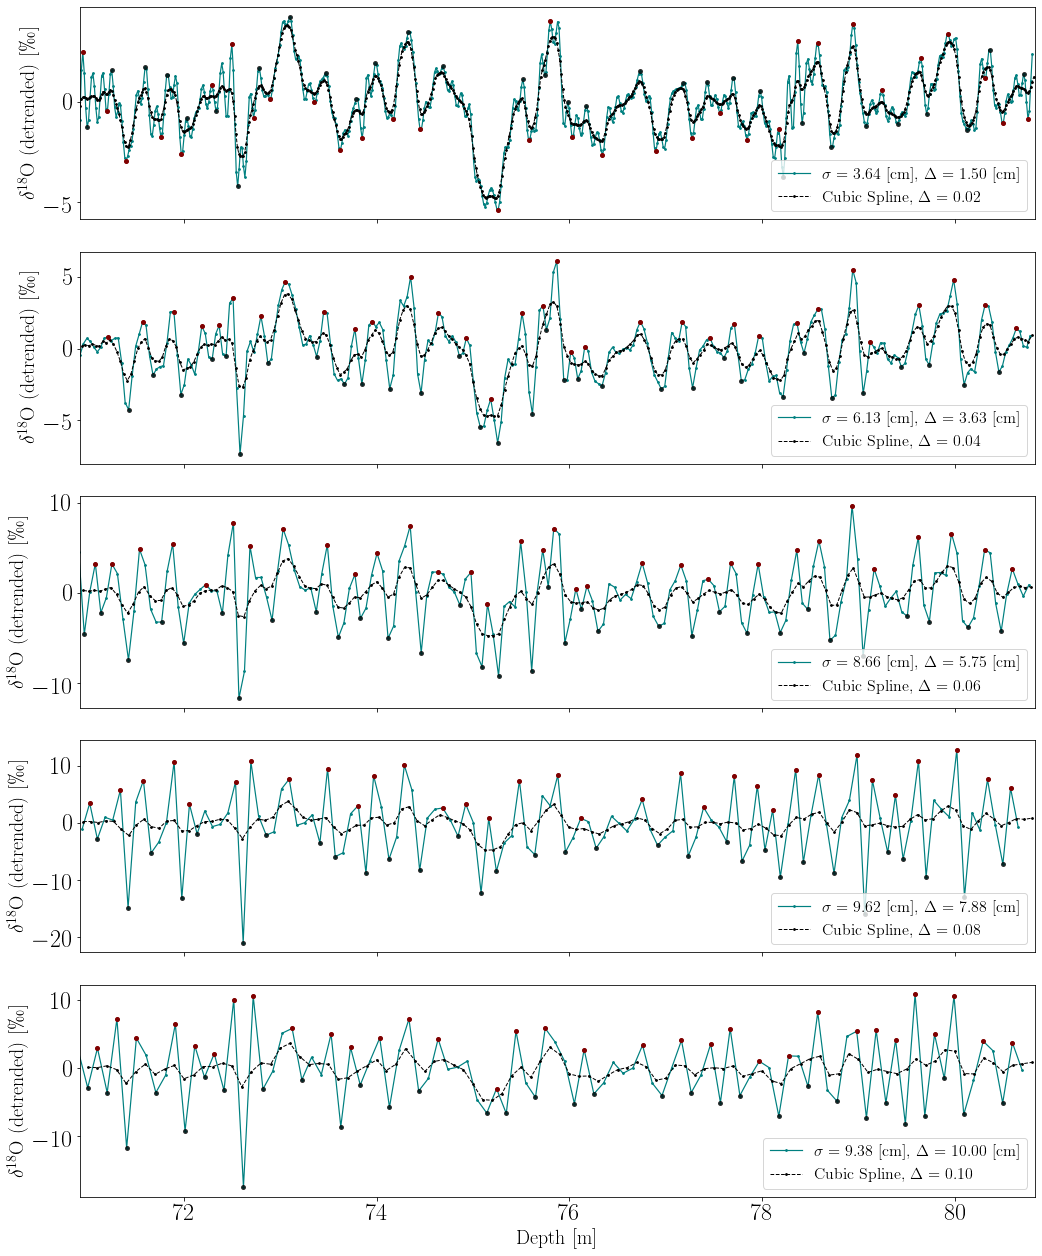

In [155]:
fig, ax = plt.subplots(len(delta_arr),1,figsize=(15,18), sharex=True)
for i in range(len(delta_arr)):
    depth = depths_BD[i]
    data = datas_BD[i]
    ax[i].plot(depth, data, lw=1.2, c='teal', marker='.', ms=3.5, label=f'$\sigma=$ {diffLens[i]*100:.2f} [cm], $\Delta=$ {delta_arr[i]*100:.2f} [cm]')
    ax[i].plot(depth_ints[i], data_ints[i]-np.mean(data_ints[i]), lw=1, ls='--', c='k', marker='.', ms=3.5, label=f'Cubic Spline, $\Delta=$ {depth_ints[i][1]-depth_ints[i][0]:.2f}')
    ax[i].plot(depth[peakss[i]],data[peakss[i]], ls='None', marker='.', c = 'maroon', ms=8)#, label=f'$N_P=${len(peakss[i])}, $N_T=${len(troughss[i])}')
    ax[i].plot(depth[troughss[i]],data[troughss[i]], ls='None', marker='.', c = 'k', alpha=0.7, ms=8)
    ax[i].set_ylabel('$\delta^{18}$O (detrended) [$\permil$]', fontsize=20)
#    if patss[i] == 1.0:
#        ax[i].plot(depth[peakss[i]],data[peakss[i]], ls='None', marker='.', c = 'maroon', ms=8, label=f'$N_P=${len(peakss[i])}, $N_T=${len(troughss[i])}\n Pattern? Yes.')
#        ax[i].plot(depth[troughss[i]],data[troughss[i]], ls='None', marker='.', c = 'k', alpha=0.7, ms=8)
#    else:
#        ax[i].plot(depth[peakss[i]],data[peakss[i]], ls='None', marker='.', c = 'maroon', ms=8, label=f'$N_P=${len(peakss[i])}, $N_T=${len(troughss[i])}\n Pattern? No.')
#        ax[i].plot(depth[troughss[i]],data[troughss[i]], ls='None', marker='.', c = 'k', alpha=0.7, ms=8)
#        
    ax[i].legend(fontsize=16, loc='lower right')

ax[-1].set_xlabel('Depth [m]', fontsize=20)
ax[-1].set_ylabel('$\delta^{18}$O (detrended) [$\permil$]', fontsize=20)
ax[-1].set(xlim=(min(depth_LT),max(depth_LT)),);
fig.tight_layout()

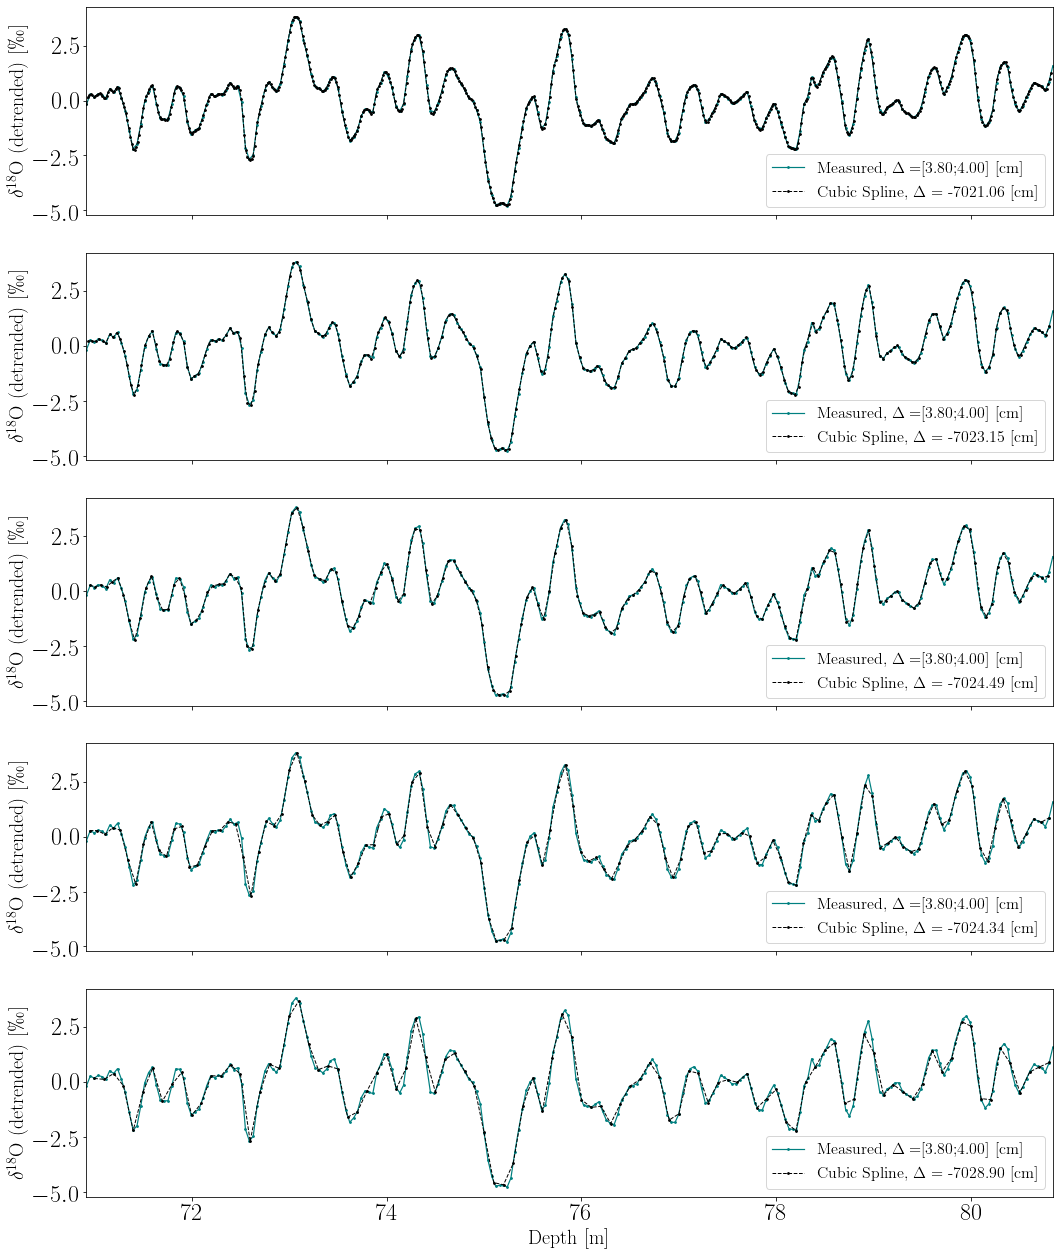

In [163]:
fig, ax = plt.subplots(len(delta_arr),1,figsize=(15,18), sharex=True)
for i in range(len(delta_arr)):
    #depth = depths_BD[i]
    #data = datas_BD[i]
    ax[i].plot(depth_LT, d18O_LT-np.mean(d18O_LT), lw=1.2, c='teal', marker='.', ms=3.5, label='Measured, $\Delta=$'+f'[{min(np.diff(depth_LT))*100:.2f};{max(np.diff(depth_LT))*100:.2f}] [cm]')
    ax[i].plot(depth_ints[i], data_ints[i]-np.mean(data_ints[i]), lw=1, ls='--', c='k', marker='.', ms=3.5, label=f'Cubic Spline, $\Delta=$ {depth_ints[i][1]-depth_ints[i][0]*100:.2f} [cm]')
    #ax[i].plot(depth[peakss[i]],data[peakss[i]], ls='None', marker='.', c = 'maroon', ms=8)#, label=f'$N_P=${len(peakss[i])}, $N_T=${len(troughss[i])}')
    #ax[i].plot(depth[troughss[i]],data[troughss[i]], ls='None', marker='.', c = 'k', alpha=0.7, ms=8)
    ax[i].set_ylabel('$\delta^{18}$O (detrended) [$\permil$]', fontsize=20)
#    if patss[i] == 1.0:
#        ax[i].plot(depth[peakss[i]],data[peakss[i]], ls='None', marker='.', c = 'maroon', ms=8, label=f'$N_P=${len(peakss[i])}, $N_T=${len(troughss[i])}\n Pattern? Yes.')
#        ax[i].plot(depth[troughss[i]],data[troughss[i]], ls='None', marker='.', c = 'k', alpha=0.7, ms=8)
#    else:
#        ax[i].plot(depth[peakss[i]],data[peakss[i]], ls='None', marker='.', c = 'maroon', ms=8, label=f'$N_P=${len(peakss[i])}, $N_T=${len(troughss[i])}\n Pattern? No.')
#        ax[i].plot(depth[troughss[i]],data[troughss[i]], ls='None', marker='.', c = 'k', alpha=0.7, ms=8)
#        
    ax[i].legend(fontsize=16)

ax[-1].set_xlabel('Depth [m]', fontsize=20)
ax[-1].set_ylabel('$\delta^{18}$O (detrended) [$\permil$]', fontsize=20)
ax[-1].set(xlim=(min(depth_LT),max(depth_LT)),);
fig.tight_layout()

# Interpolation af. vs. Diffusion Length

In [70]:
site = 'SiteA'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb_in = CoreSpecs['dTambCor']
dLaki_in = CoreSpecs['dLakiCor']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


In [71]:
pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

data = pd.read_csv(pathResults + site +'_DiffLensVdelta_InterpAF_const'+'.txt', '\t')


## Quantitatively, delta vs diff len

In [72]:
delta_arr_in = np.arange(0.01,0.07,0.0002)
shift_in = 1.5
lSecs_in=7
sites = ['SiteB']
for j in range(len(sites)):

        # Load data
    site = sites[j]
    N_InInt = 33

    print(f'\n {site}')
    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

    coreNames = CoresSpecs['CoreName']


    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTamb = CoreSpecs['dTamb']
    dLaki = CoreSpecs['dLaki']
    accum0 = CoreSpecs['Accum0']
    accumIE = CoreSpecs['Accum1']
    Temp0 = CoreSpecs['T0']

    DataAll = GetCoreData(site, 'Alphabet')

    data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
    data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
    data_dens = DataAll[4]; data_dens_LT = DataAll[5]
    data_diff = DataAll[6]; data_diff_LT = DataAll[7]


    depth = data_d18O['depth']
    d18O = data_d18O['d18O']

    depth_LT = data_d18O_LT['depth']
    d18O_LT = data_d18O_LT['d18O']
    isoData = data_d18O


    delta_arr = delta_arr_in
    diffLens = []
    #    depths = []
    #    datas = []
    #    peakss = []

    inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)

    for i in range(len(delta_arr)):

        print(f'\n\t\tRun {i} of {len(delta_arr)}')
        try:
            depth1, data, diffLen, Peaks, Ts, pats = inst.BackDiffused_constraints(interpAfterDecon=True, newDelta=delta_arr[i])
        #        depths.append(depth1)
        #        datas.append(data)
            diffLens.append(diffLen)

        except:
            print('Error, moving on to next $\Delta$')
            diffLens.append(-1)
    df_Site = pd.DataFrame({'diffLens':diffLens, 'deltas':delta_arr})



 SiteB

		Run 0 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 1 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 7.34 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.010

		Run 2 of 300
ALT file exists. Loading ALT data.
Error, moving on to next $\Delta$

		Run 3 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 4 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 5 of 300
ALT file exists. Loading ALT data.
Error, moving on to next $\Delta$

		Run 6 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 7 of 300
ALT file exists.

Error, moving on to next $\Delta$

		Run 57 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 58 of 300
ALT file exists. Loading ALT data.
Error, moving on to next $\Delta$

		Run 59 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 60 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 61 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 62 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 63 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, m

Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 113 of 300
ALT file exists. Loading ALT data.
Error, moving on to next $\Delta$

		Run 114 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 115 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 116 of 300
ALT file exists. Loading ALT data.
Error, moving on to next $\Delta$

		Run 117 of 300
ALT file exists. Loading ALT data.
Error, moving on to next $\Delta$

		Run 118 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 119 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 120 of 300
ALT file exist

Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 172 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 173 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 174 of 300
ALT file exists. Loading ALT data.
Error, moving on to next $\Delta$

		Run 175 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 176 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 177 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 178 of 300
ALT file exists. Loading ALT data.
S

Error, moving on to next $\Delta$

		Run 226 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 227 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 228 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 229 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 230 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 231 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 232 of 300
ALT file exists. Loading ALT data.
S

Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 284 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 285 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 286 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 287 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 288 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to next $\Delta$

		Run 289 of 300
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Error, moving on to nex

In [89]:
site = 'SiteG'
df_Site = pd.read_csv(pathResults + site + '_DiffLensVdelta_InterpAF_const.txt','\t')

[(0.09319543502878527, 0.12179519019488375)]

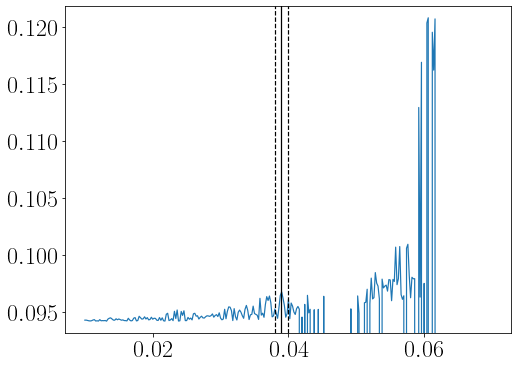

In [90]:
sigs = df_Site['diffLens']
dels = df_Site['deltas']

fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(dels[sigs>0], sigs[sigs>0])
ax.plot(dels,sigs, lw=1.2)
ax.axvline(max(np.diff(depth_LT)), ls='--',c='k', lw=1.2)
ax.axvline(min(np.diff(depth_LT)), ls='--',c='k', lw=1.2)
ax.axvline(np.mean(np.diff(depth_LT)), ls='-',c='k', lw=1.24)

ax.set(ylim=(min(sigs[sigs>0])-0.001,max(sigs)+0.001))#, xlim=(min(dels),0.055))

In [91]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG']

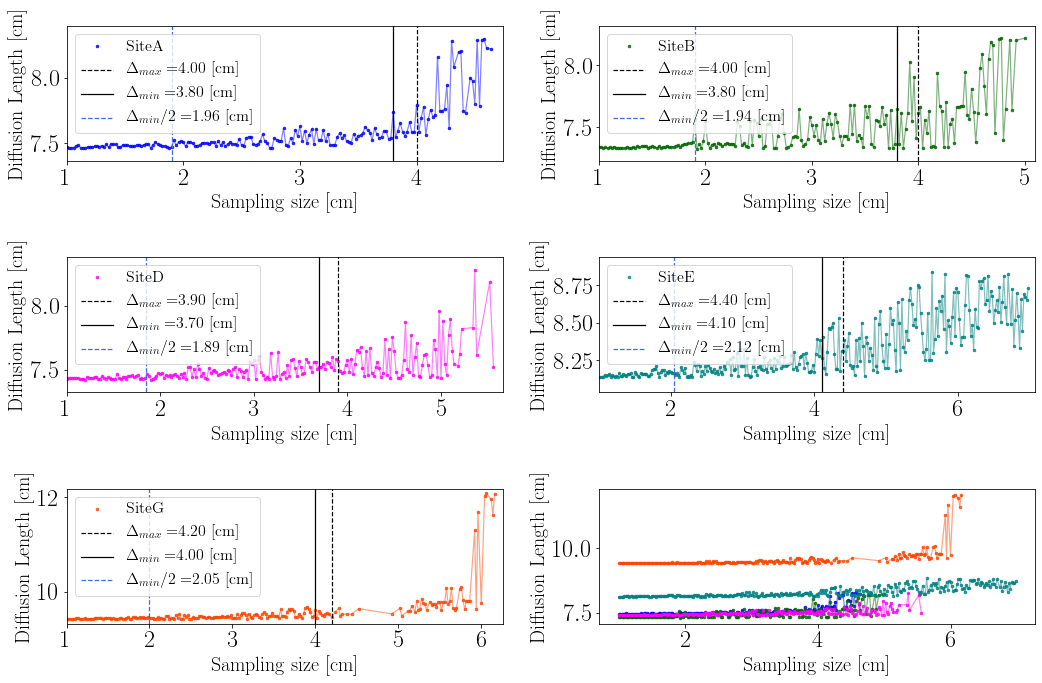

In [144]:
fig, axs = plt.subplots(int(np.ceil(len(sites)/2)), 2, figsize=(15,10))
colors = ['blue','darkgreen','magenta','teal','orangered']

for i in range(len(sites)):
    site = sites[i]
    
    
    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

    coreNames = CoresSpecs['CoreName']


    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]

    DataAll = GetCoreData(site, 'Alphabet')

    data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]

    depth_LT = data_d18O_LT['depth']
    data_LT = data_d18O_LT['d18O']
    
    df_Site = pd.read_csv(pathResults + site + '_DiffLensVdelta_InterpAF_const.txt','\t')
    sigs = df_Site['diffLens']*100
    dels = df_Site['deltas']*100
    sigs0 = sigs[sigs>0]
    dels0 = dels[sigs>0]
    
    ax = axs.flatten()[i]
    
    ax.plot(dels[sigs>0], sigs[sigs>0], lw=1.2,marker='.', ls='None', ms=5, c=colors[i], alpha=0.8, label=site)
    ax.plot(dels[sigs>0], sigs[sigs>0], lw=1.2, c=colors[i], alpha=0.5)
    #ax.plot(dels,sigs, lw=1.2)
    ax.axvline(max(np.diff(depth_LT))*100, ls='--',c='k', lw=1.2, label='$\Delta_{max}=$'+f'{max(np.diff(depth_LT))*100:.2f} [cm]')
    #ax.axvline(min(np.diff(depth_LT))*100, ls='--',c='k', lw=1.2)
    ax.axvline(min(np.diff(depth_LT))*100, ls='-',c='k', lw=1.24, label='$\Delta_{min}=$'+f'{min(np.diff(depth_LT))*100:.2f} [cm]')
    ax.axvline(min(np.diff(depth_LT))/2*100, ls='--',c='royalblue', lw=1.24, label='$\Delta_{min}/2=$'+f'{np.mean(np.diff(depth_LT))/2*100:.2f} [cm]')
    ax.legend(fontsize=16, loc='upper left')
    ax.set(ylim=(min(sigs0)-0.1,max(sigs0)+0.1), xlim=(min(dels0),max(dels0)+0.1))
    ax.set_xlabel('Sampling size [cm]', fontsize=20)
    ax.set_ylabel('Diffusion Length [cm]', fontsize=20)#, xlim=(min(dels),0.055))
    
    axs.flatten()[-1].plot(dels[sigs>0], sigs[sigs>0], lw=1.2,marker='.', ls='None', ms=5, c=colors[i], alpha=0.8, label=site)
    axs.flatten()[-1].plot(dels[sigs>0], sigs[sigs>0], lw=1.2, c=colors[i], alpha=0.5)
    axs.flatten()[-1].set_xlabel('Sampling size [cm]', fontsize=20)
    axs.flatten()[-1].set_ylabel('Diffusion Length [cm]', fontsize=20)

    fig.tight_layout()

## Qualitatively, focus on specific resamplings

In [122]:
delta_arr_in = [0.01, 0.02,0.03,0.04, 0.05]

site = 'SiteB'
N_InInt = 33

print(f'\n {site}')
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
isoData = data_d18O


delta_arr = delta_arr_in
diffLens = np.zeros(len(delta_arr))
depths = []
datas = []
peakss = []
troughss = []
patss = []

inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)

for i in range(len(delta_arr)):

    print(f'\n\t\tRun {i} of {len(delta_arr)}')
    
    depth1, data, diffLen, Peaks, Ts, pats = inst.BackDiffused_constraints(interpAfterDecon=True, newDelta=delta_arr[i])
    depths.append(depth1)
    datas.append(data)
    peakss.append(Peaks)
    troughss.append(Ts)
    patss.append(pats)
    
    diffLens[i] = diffLen

#    except:
#        print('Error, moving on to next $\Delta$')
#        depths.append(np.zeros(len(depth1)))
#        datas.append(np.zeros(len(depth1)))
#        peakss.append(np.zeros(len(Peaks)))
#        troughss.append(np.zeros(len(Ts)))
#        diffLens[i] = -1
#        
#df_Site = pd.DataFrame({'diffLens':diffLens, 'deltas':delta_arr})



 SiteB

		Run 0 of 5
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 7.34 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.010

		Run 1 of 5
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 7.39 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.020

		Run 2 of 5
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 7.43 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.030

		Run 3 of 5
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 7.33 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.040

		Run 4 of 5
ALT file exists. Loading ALT data.
Sigma fit: 7.59
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 8.22 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.050


In [155]:
patss

[1.0, 1.0, 1.0, 1.0, 1.0]

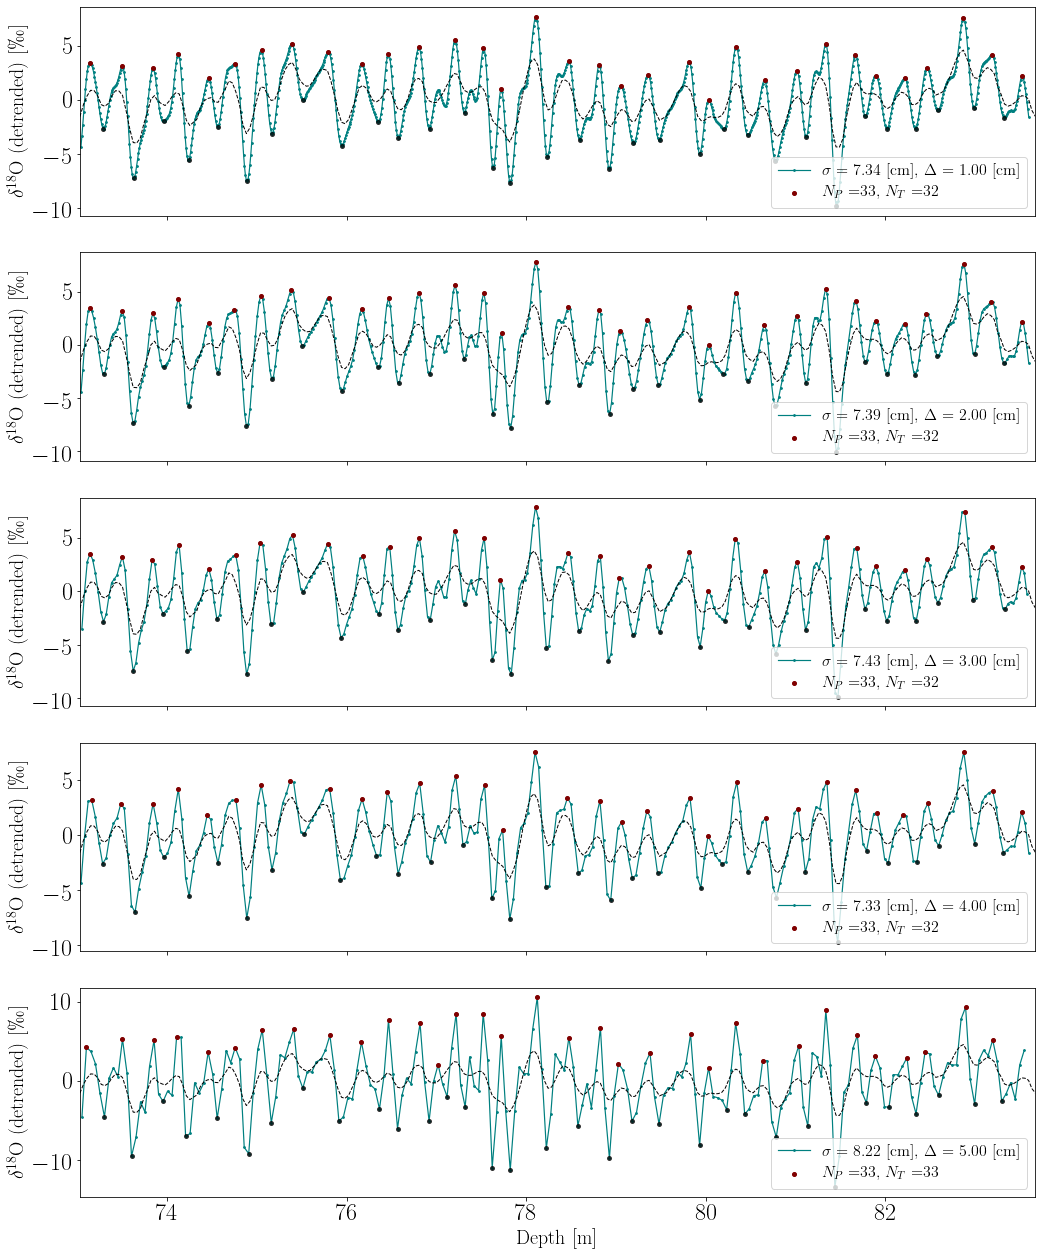

In [172]:
fig, ax = plt.subplots(len(delta_arr),1,figsize=(15,18), sharex=True)
for i in range(len(delta_arr)):
    depth = depths[i]
    data = datas[i]
    ax[i].plot(depth, data, lw=1.2, c='teal', marker='.', ms=3.5, label=f'$\sigma=$ {diffLens[i]*100:.2f} [cm], $\Delta=$ {delta_arr[i]*100:.2f} [cm]')
    ax[i].plot(depth_LT,d18O_LT-np.mean(d18O_LT), lw=1, ls='--', c='k')
    ax[i].plot(depth[peakss[i]],data[peakss[i]], ls='None', marker='.', c = 'maroon', ms=8, label=f'$N_P=${len(peakss[i])}, $N_T=${len(troughss[i])}')
    ax[i].plot(depth[troughss[i]],data[troughss[i]], ls='None', marker='.', c = 'k', alpha=0.7, ms=8)
    ax[i].set_ylabel('$\delta^{18}$O (detrended) [$\permil$]', fontsize=20)
#    if patss[i] == 1.0:
#        ax[i].plot(depth[peakss[i]],data[peakss[i]], ls='None', marker='.', c = 'maroon', ms=8, label=f'$N_P=${len(peakss[i])}, $N_T=${len(troughss[i])}\n Pattern? Yes.')
#        ax[i].plot(depth[troughss[i]],data[troughss[i]], ls='None', marker='.', c = 'k', alpha=0.7, ms=8)
#    else:
#        ax[i].plot(depth[peakss[i]],data[peakss[i]], ls='None', marker='.', c = 'maroon', ms=8, label=f'$N_P=${len(peakss[i])}, $N_T=${len(troughss[i])}\n Pattern? No.')
#        ax[i].plot(depth[troughss[i]],data[troughss[i]], ls='None', marker='.', c = 'k', alpha=0.7, ms=8)
#        
    ax[i].legend(fontsize=16)

ax[-1].set_xlabel('Depth [m]', fontsize=20)
ax[-1].set_ylabel('$\delta^{18}$O (detrended) [$\permil$]', fontsize=20)
ax[-1].set(xlim=(min(depth_LT),max(depth_LT)),);
fig.tight_layout()

# sigma_const vs. sigma(z)

# N Peaks vs. Diffusion Length

In [317]:
#site = 'SiteG'

pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'
diffLens,N_Ps,N_Ts,patterns = np.asarray(pd.read_csv(pathResults + site+'diffLensVNpeaks_constrained.csv', ' ', header=None))

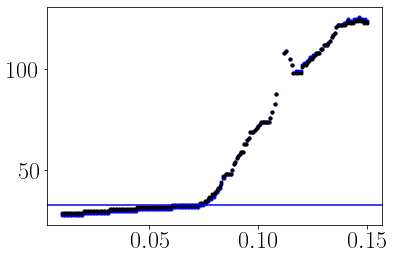

In [318]:
plt.plot(diffLens[patterns>0],N_Ts[patterns>0],'.',c='b')
plt.plot(diffLens[patterns>0],N_Ps[patterns>0],'.',c='k')
plt.axhline(33, c='b')
#plt.axvline(diffLen0_in)

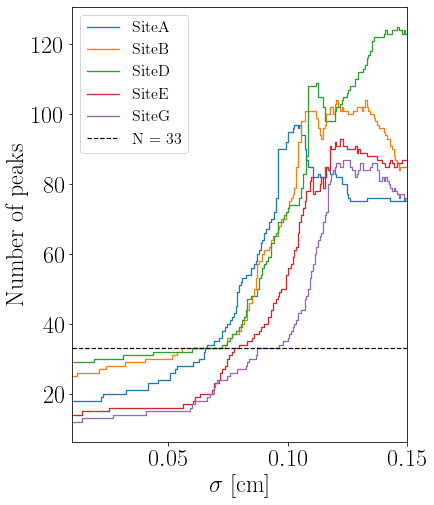

In [266]:
sites = ['SiteA','SiteB','SiteD','SiteE','SiteG']

fig, ax = plt.subplots(1,1,figsize=(6,8))

ax.set(xlim=(0.01,0.15), xlabel='$\sigma$ [cm]', ylabel='Number of peaks')
#ax[1].set(xlim=(0.01,0.15), xlabel='$\sigma$ [cm]', ylabel='Number of troughs')
for site in sites:
    diffLens,N_Ps,N_Ts,patterns = np.asarray(pd.read_csv(pathResults + site+'diffLensVNpeaks_constrained.csv', ' ', header=None))
    ax.step(diffLens[patterns>0],N_Ps[patterns>0], lw=1.3, label=site)#,c='b')
    #ax.step(diffLens,N_Ps, lw=1.3, label=site)#,c='b')
    #ax[1].step(diffLens[patterns>0],N_Ts[patterns>0], lw=1.3, label=site)#,c='b')
    #plt.plot(diffLens[patterns>0],N_Ps[patterns>0],'.')#,c='k')
ax.axhline(33, lw=1.2,c='k',ls='--', label='N = 33')
#ax[1].axhline(33, lw=1.2,c='k',ls='--', label = 'N = 33')

ax.legend(fontsize=16)
#ax[1].legend(fontsize=16)

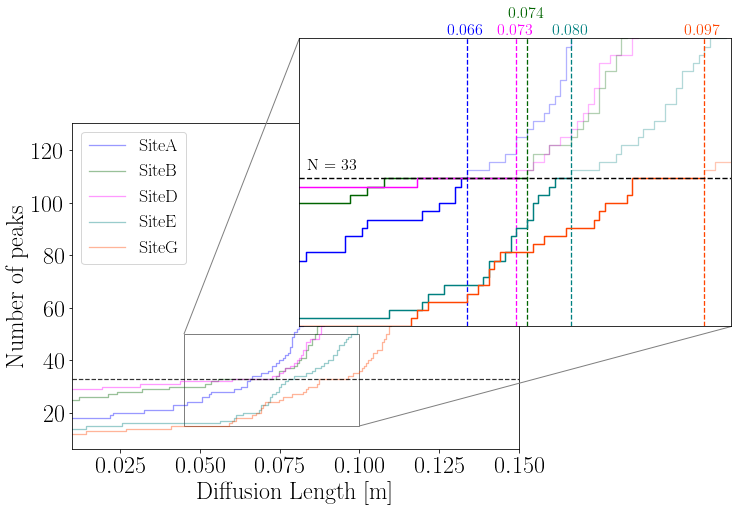

In [268]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams.update({'font.size': 22})
colors = ['blue','darkgreen','magenta','teal','orangered']

for i in range(len(sites)):
    diffLens,N_Ps,N_Ts,patterns = np.asarray(pd.read_csv(pathResults + sites[i]+'diffLensVNpeaks_constrained.csv', ' ', header=None))
    ax.step(diffLens[patterns>0],N_Ps[patterns>0], lw=1.3, label=sites[i], c = colors[i], alpha=0.4)#,c='b')

ax.axhline(y=33,ls='--',color='k', lw=1.2, alpha=0.8)
ax.set(xlabel='Diffusion Length [m]', ylabel='Number of peaks', xlim=(0.01,0.15))
ax.legend(fontsize=18)



x1 = 0.045
x2 = 0.1
y1 = 15
y2 = 50


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axins = inset_axes(ax, 6,4, loc=2, bbox_to_anchor=(0.5,0.1,1,1), bbox_transform=ax.figure.transFigure)#loc=5) # zoom = 2
for i in range(len(sites)):
    diffLens,N_Ps,N_Ts,patterns = np.asarray(pd.read_csv(pathResults + sites[i]+'diffLensVNpeaks_constrained.csv', ' ', header=None))
    diffLensUse = diffLens[patterns>0]
    N_PsUse = N_Ps[patterns>0]
    sigMax = diffLensUse[N_PsUse <= 33][-1]
    
    axins.step(diffLensUse, N_PsUse, lw=1.3, label=site, alpha=0.3, c=colors[i])#,c='b')
    axins.step(diffLensUse[N_PsUse <= 33], N_PsUse[N_PsUse <= 33], lw=1.4, label=site, c=colors[i])#,c='b')
    axins.axvline(sigMax, c=colors[i], lw=1.3, ls='--')
    if i == 1:
        axins.text(sigMax-0.0025, y2+0.5+2.0, f'{sigMax:.3f}', c=colors[i], fontsize=16)
    else:
        axins.text(sigMax-0.0025, y2+0.5, f'{sigMax:.3f}', c=colors[i], fontsize=16)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
axins.text(x1+0.001, 33+1,'N = 33', fontsize=16)

axins.axhline(y=33, ls='--', c='k', lw=1.4)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5");

    

# Final sigma estimates, based on previous conclusions